In [141]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [142]:
import sys
import os
sys.path.append(os.path.abspath(".."))

from metrics.charts import TrainingCharts
from datasets.xor import XOR
from experiment.runExperiment import RunExperiment
from experiment.models import ModelSetups
from training.train import TrainUtil
from metrics.charts import ChartUtil

In [152]:
dataset = XOR()
in_features = 2
out_features = 2
X_train, y_train, X_val, y_val = dataset.get_dataset(in_features = in_features, unique = False)
trainUtil = TrainUtil(X_train, y_train, X_val = X_val, y_val = y_val)

In [153]:
experiment = RunExperiment(trainUtil)
modelSetups = ModelSetups()
trainUtil.set_data_granularity(1)

In [154]:
denseModel = "Dense Model"
denseControlModel = "Dense Control Model"
sparseModel = "Sparse Model"

In [146]:
results = experiment.train_models(
    models = {
        "Sparse Model": modelSetups._get_sparse_model,
        "Dense Model": modelSetups._get_dense_model,
        "Dense Control Model": modelSetups._get_dense_model,
    },
    in_features = in_features, 
    out_features = out_features, 
    layers = 3,  
    model_params = {"l1": (200, 15), "l2": (250, None), "l3": (200, None)},
    n_epochs=150,
)

In [147]:
import torch
activations = {}
with torch.no_grad():
    for modelName, model in results.items():
        op, activations[modelName] = model.forward(X_val, return_acts = True)
layers = list(activations['Sparse Model'].keys())

In [8]:
for layer in layers:
    print(f"--- {layer} ---")
    for model_name, acts in activations.items():
        a = acts[layer]
        print(f"{model_name:7s} mean={a.mean():.4f}, std={a.std():.4f}, sparsity={(a==0).float().mean():.4f}")

--- l1 ---
Sparse Model mean=0.0764, std=0.2776, sparsity=0.9250
Dense Model mean=0.1850, std=0.3023, sparsity=0.0000
Dense Control Model mean=0.2468, std=0.3365, sparsity=0.0000
--- l2 ---
Sparse Model mean=0.2349, std=0.4937, sparsity=0.0000
Dense Model mean=0.0484, std=0.5809, sparsity=0.0000
Dense Control Model mean=0.0830, std=1.2791, sparsity=0.0000
--- l3 ---
Sparse Model mean=1.7919, std=2.6886, sparsity=0.0000
Dense Model mean=0.8557, std=1.6584, sparsity=0.0000
Dense Control Model mean=1.4088, std=4.3909, sparsity=0.0000
--- out ---
Sparse Model mean=17.3878, std=22.2747, sparsity=0.0000
Dense Model mean=5.2239, std=5.7692, sparsity=0.0000
Dense Control Model mean=7.5826, std=13.4839, sparsity=0.0000


In [9]:
import torch.nn.functional as F

def cosine_similarity_per_sample(a, b):
    return F.cosine_similarity(a.flatten(start_dim=1), b.flatten(start_dim=1)).mean()

for layer in layers:
    sim = cosine_similarity_per_sample(activations[denseModel][layer], activations[sparseModel][layer])
    print(f"{layer:10s}: cosine similarity between dense and sparse = {sim:.4f}")
    sim = cosine_similarity_per_sample(activations[denseModel][layer], activations[denseControlModel][layer])
    print(f"{layer:10s}: cosine similarity between dense and control = {sim:.4f}")

l1        : cosine similarity between dense and sparse = 0.1096
l1        : cosine similarity between dense and control = 0.2947
l2        : cosine similarity between dense and sparse = 0.0297
l2        : cosine similarity between dense and control = -0.0275
l3        : cosine similarity between dense and sparse = 0.2704
l3        : cosine similarity between dense and control = 0.1585
out       : cosine similarity between dense and sparse = 0.9944
out       : cosine similarity between dense and control = 0.9753


In [10]:
def normalize_activations(a, eps=1e-8):
    return (a - a.mean()) / (a.std() + eps)

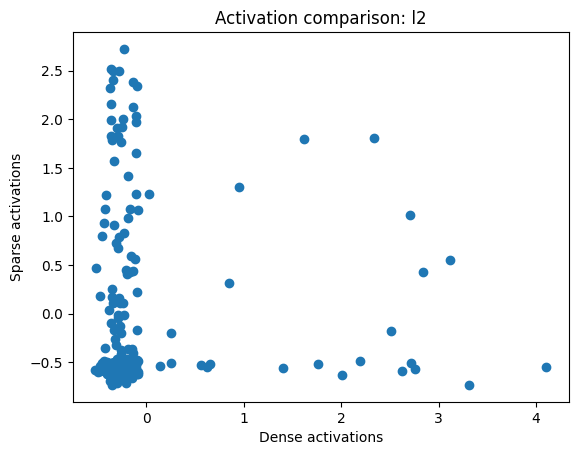

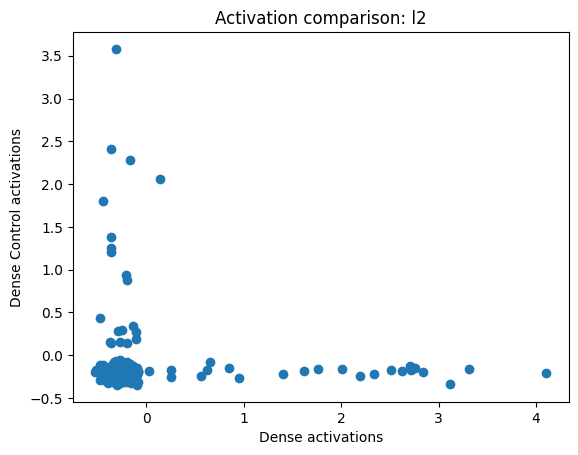

In [18]:
import matplotlib.pyplot as plt
import numpy as np

layer = layers[1]
dense_act = activations[denseModel][layer]
dense_control_act = activations[denseControlModel][layer]
sparse_act = activations[sparseModel][layer]

dense_act = normalize_activations(dense_act)
dense_control_act = normalize_activations(dense_control_act)
sparse_act = normalize_activations(sparse_act)

plt.scatter(dense_act[0].numpy(), sparse_act[0].numpy())
plt.xlabel("Dense activations")
plt.ylabel("Sparse activations")
plt.title(f"Activation comparison: {layer}")
plt.show()

plt.scatter(dense_act[0].numpy(), dense_control_act[0].numpy())
plt.xlabel("Dense activations")
plt.ylabel("Dense Control activations")
plt.title(f"Activation comparison: {layer}")
plt.show()

In [32]:
X_val[0].tolist()

[0.0, 0.0]

In [164]:

def get_cosine_similarity_matrix(acts, num_inputs = 4):
    cosine_sim_matrix = torch.zeros((num_inputs, num_inputs))
    for i in range(num_inputs):
        for j in range(num_inputs):
            cosine_sim_matrix[i, j] = F.cosine_similarity(acts[i], acts[j], dim=0)
    return cosine_sim_matrix.numpy()

def get_similarity_plot(acts, modelName, layerName, num_inputs=4, input_labels=None, fig=None, ax=None):
    # Compute cosine similarity matrix
    cosine_sim_matrix = get_cosine_similarity_matrix(acts, num_inputs)

    # Default labels
    if input_labels is None:
        input_labels = [f'Input {X_val[i].tolist()}' for i in range(num_inputs)]

    # Create figure and axes if not provided
    if fig is None or ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    # Plot heatmap
    im = ax.imshow(cosine_sim_matrix, cmap='viridis', interpolation='nearest')

    # Add colorbar
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('Cosine Similarity')

    # Set ticks and labels
    ax.set_xticks(range(num_inputs))
    ax.set_yticks(range(num_inputs))
    ax.set_xticklabels(input_labels, rotation=45, ha='right')
    ax.set_yticklabels(input_labels)
    ax.set_title(f'Cosine Similarity Heatmap for {modelName} and Layer "{layerName}"')
    ax.set_aspect('equal')

    return fig

In [156]:
layers = 3
model_params_all = {"l1": (200, 15), "l2": (250, 20), "l3": (200, 10)}
model_params_first = {"l1": (200, 15), "l2": (250, None), "l3": (200, None)}
model_params_second = {"l1": (200, None), "l2": (250, 20), "l3": (200, None)}
model_params_third = {"l1": (200, None), "l2": (250, None), "l3": (200, 10)}
model_params_first_second = {"l1": (200, 15), "l2": (250, 20), "l3": (200, None)}
model_params_first_third = {"l1": (200, 15), "l2": (250, None), "l3": (200, 10)}
model_params_second_third = {"l1": (200, None), "l2": (250, 20), "l3": (200, 10)}

In [ ]:
model_types = {"Complete Sparse model": model_params_all, 
               "1st L Sparse": model_params_first, 
               "2nd L Sparse": model_params_second,
               "3rd L Sparse": model_params_third,
               "1st and 2nd L Sparse": model_params_first_second,
               "1st and 3rd L Sparse": model_params_first_third,
               "2nd and 3rd L Sparse": model_params_second_third
            }
def get_models(modelTypes = model_types, completeModel = "Complete Sparse model"):

    sparseResults = experiment.train_models(
        models = 
        {
            "Control Model": modelSetups._get_control_model,
            "Dense Model": modelSetups._get_dense_model,
        },
        in_features = in_features, 
        out_features = out_features, 
        layers = 3,  
        model_params = modelTypes[completeModel],
        n_epochs=150,
        # batch_train= True
    )

    for modelName in modelTypes:
        sparseResults = sparseResults | experiment.train_models(
            models = {
                modelName: modelSetups._get_sparse_model,
                modelName + " Ortho": modelSetups._get_sparse_model
                },
            in_features = in_features, 
            out_features = out_features, 
            layers = 3, 
            model_params = modelTypes[modelName],
            n_epochs = 150,
            # batch_train= True
            )
    return sparseResults

In [ ]:
from metrics.accuracy import get_accuracy
sparseResults = get_models()
sparseActivations = {}
with torch.no_grad():
    for modelName, model in sparseResults.items():
        op, sparseActivations[modelName] = model.forward(X_val, return_acts = True)
        accuracy = get_accuracy(model, X_val, y_val)
        if accuracy != 1.:
            print(modelName, accuracy)
layers = list(sparseActivations[0]['Sparse Model'].keys())

In [226]:
allActivations = []
n_runs = 50
for _ in range(n_runs):
    sparseResults = get_models()
    sparseActivations = {}
    with torch.no_grad():
        for modelName, model in sparseResults.items():
            op, sparseActivations[modelName] = model.forward(X_val, return_acts = True)
            accuracy = get_accuracy(model, X_val, y_val)
            if accuracy != 1.:
                print(modelName, accuracy)
    allActivations.append(sparseActivations)
layers = list(allActivations[0]['Complete Sparse model'].keys())

In [273]:
import numpy as np

def compute_within_between_similarity(sim_matrix, avg = True):
    if avg:
        within = [sim_matrix[0, 3], sim_matrix[1, 2]]
        between = [sim_matrix[0, 1], sim_matrix[0, 2], sim_matrix[1, 3], sim_matrix[2, 3]]
        return np.mean(within), np.mean(between)
    else:
        within = {"00-11":sim_matrix[0, 3], "01-10": sim_matrix[1, 2]}
        between = {"00-01": sim_matrix[0, 1], "00-10": sim_matrix[0, 2], "11-01": sim_matrix[1, 3],"11-10": sim_matrix[2, 3]}
        return within, between

# Example usage after you compute cosine_sim_matrix:
integration = {}
separation = {}
for sparseActivations in allActivations:
    for modelName in sparseActivations:
        for layerName in layers:
            acts = sparseActivations[modelName][layerName]  # shape: (4, 250)

            # Compute cosine similarities
            # We'll compare each pair of the 4 activations
            num_inputs = acts.shape[0]
            if modelName not in integration.keys():
                integration[modelName] = {}
            if layerName not in integration[modelName]:
                integration[modelName][layerName] = []
            if modelName not in separation.keys():
                separation[modelName] = {}
            if layerName not in separation[modelName]:
                separation[modelName][layerName] = []

            cosine_sim_matrix = get_cosine_similarity_matrix(acts, num_inputs)
            within_sim, between_sim = compute_within_between_similarity(cosine_sim_matrix, False)
            integration[modelName][layerName].append(within_sim)
            separation[modelName][layerName].append(between_sim)
            

In [277]:
combined = {}

for key in integration.keys():
    combined[key] = {}
    for subkey in integration[key].keys():
        combined[key][subkey] = [
    {**i, **s} for i, s in zip(integration[key][subkey], separation[key][subkey])
]

In [279]:
combined['Control Model']['l1'][0], integration['Control Model']['l1'][0], separation['Control Model']['l1'][0]

({'00-11': np.float32(0.34507844),
  '01-10': np.float32(0.29802114),
  '00-01': np.float32(0.4800286),
  '00-10': np.float32(0.58122647),
  '11-01': np.float32(0.7343847),
  '11-10': np.float32(0.65107834)},
 {'00-11': np.float32(0.34507844), '01-10': np.float32(0.29802114)},
 {'00-01': np.float32(0.4800286),
  '00-10': np.float32(0.58122647),
  '11-01': np.float32(0.7343847),
  '11-10': np.float32(0.65107834)})

In [301]:
labels = {0: "00", 1: "01", 2:"10", 3:"11"}
def getLineChart(xData, yDataList, labels, avg = True):
        figures = {}
        for i in range(len(yDataList)):
            for modelName in yDataList[i]:
                if avg:
                    fig, ax = plt.subplots()
                    if modelName not in figures.keys():
                        figures[modelName] = {}
                    figures[modelName][labels[i]] = fig
                    ax.set_xlabel("Run Number")
                for layerName in yDataList[i][modelName]:
                    if not avg:
                        fig, ax = plt.subplots()
                        if modelName not in figures.keys():
                            figures[modelName] = {}
                        if labels[i] not in figures[modelName].keys():
                            figures[modelName][labels[i]] = {}

                        figures[modelName][labels[i]][layerName] = fig
                        ax.set_xlabel("Run Number")
                    if avg:
                            ax.plot(xData, yDataList[i][modelName][layerName], label=layerName)
                    else:
                        values = {}
                        for value in yDataList[i][modelName][layerName]:
                            for pair in value:
                                if pair not in values.keys():
                                     values[pair] = []
                                values[pair].append(value[pair])
                        for pair in values:
                            ax.plot(xData, values[pair], label=pair)
                    if not avg:
                        ax.legend()
                        ax.set_title(labels[i] + " " + modelName + " " + layerName)
                if avg:
                    ax.legend()
                    ax.set_title(labels[i] + " " + modelName)

        return figures
def getErrorBarChart(yDataList, labels):
        figures = {}
        for i in range(len(yDataList)):
            for modelName in yDataList[i]:
                fig, ax = plt.subplots()
                if modelName not in figures.keys():
                    figures[modelName] = {}
                figures[modelName][labels[i]] = fig
                ax.set_xlabel("Run Number")
                mean_vals = []
                std_vals = []
                for layerName in yDataList[i][modelName]:
                    mean = np.mean(yDataList[i][modelName][layerName])
                    std_dev = np.std(yDataList[i][modelName][layerName])
                    mean_vals.append(mean)
                    std_vals.append(std_dev)
                ax.errorbar(list(yDataList[i][modelName].keys())  , y = mean_vals, yerr= std_vals)
                ax.legend()
                ax.set_title(labels[i] + " " + modelName)

        return figures
def getErrorBarChartIndivid(yDataList):
        figures = {}
        for modelName in yDataList:
            fig, ax = plt.subplots()
            if modelName not in figures.keys():
                figures[modelName] = {}
            figures[modelName] = fig
            ax.set_xlabel("Run Number")
            for layerName in yDataList[modelName]:
                mean_vals = []
                std_vals = []
                labels = []
                layer_dicts = yDataList[modelName][layerName]
                for label in layer_dicts[0].keys():
                    items = [item[label] for item in layer_dicts]

                    mean = np.mean(items)
                    std_dev = np.std(items)

                    mean_vals.append(mean)
                    std_vals.append(std_dev)

                labels = list(layer_dicts[0].keys())
                ax.errorbar(labels , y = mean_vals, yerr= std_vals, label = layerName)
            ax.legend()
            ax.set_title(modelName)

        return figures



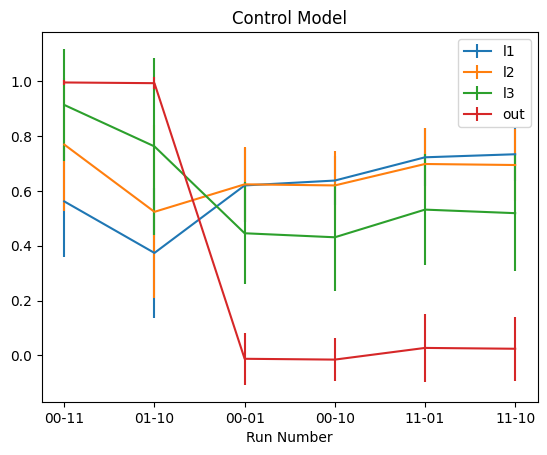

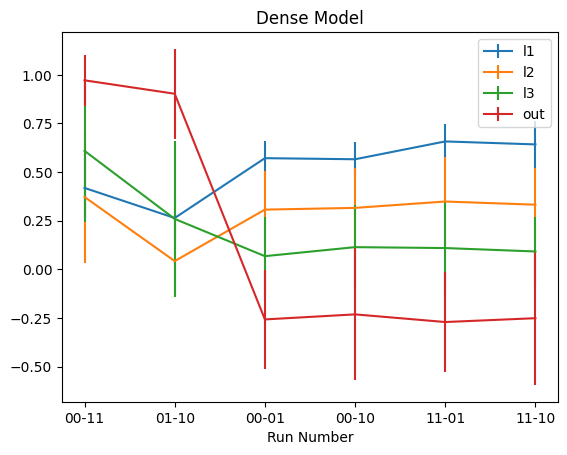

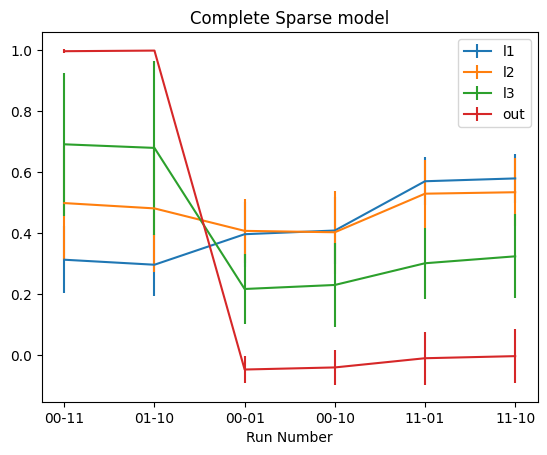

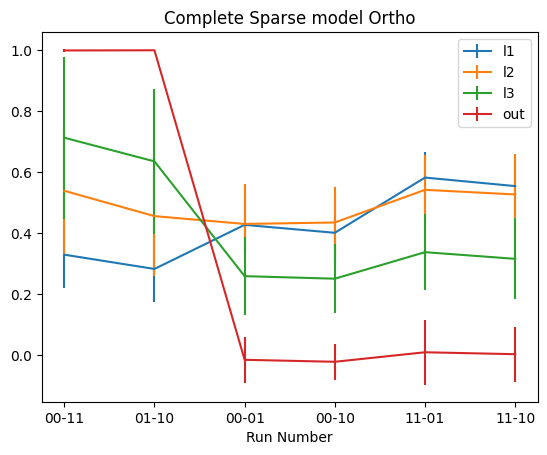

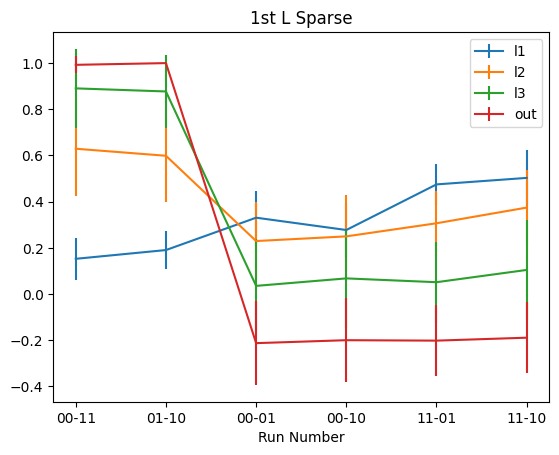

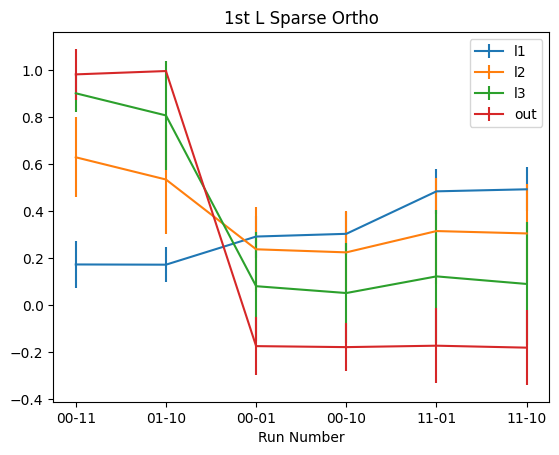

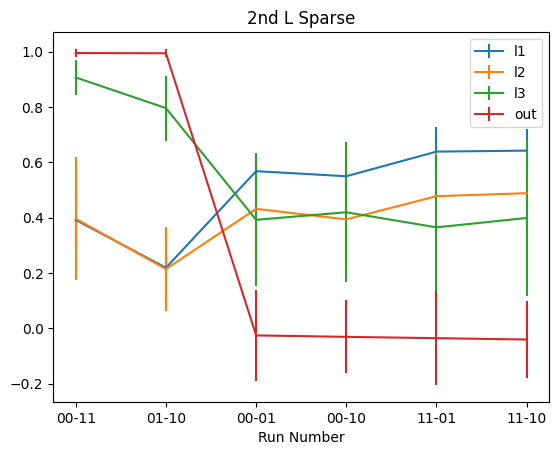

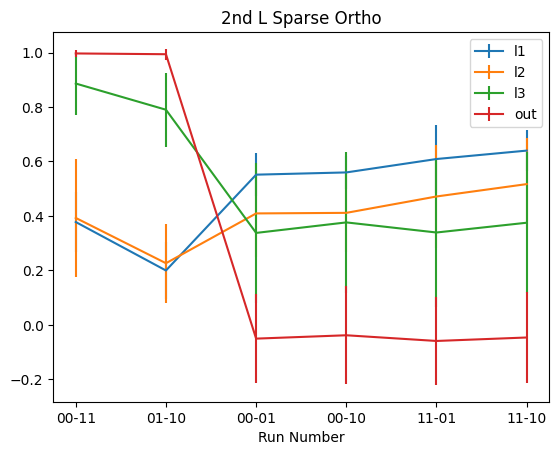

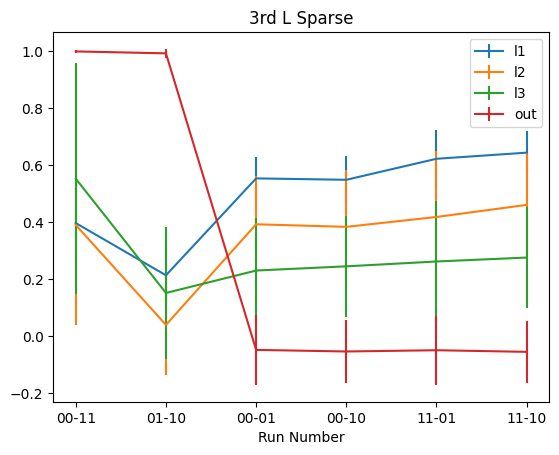

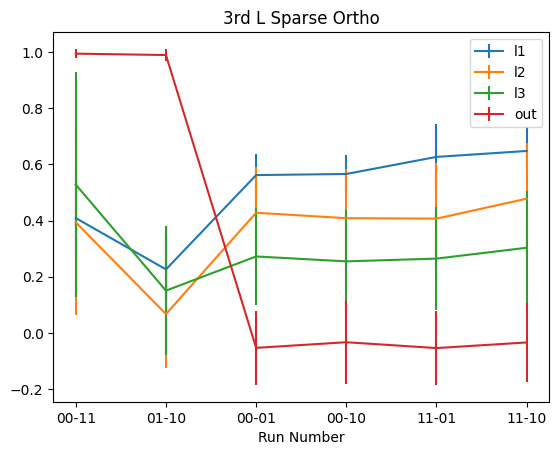

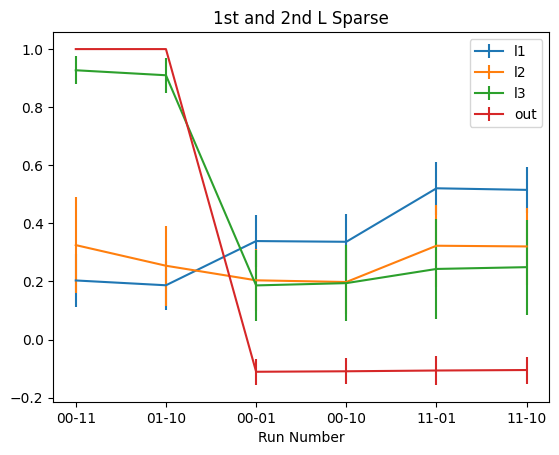

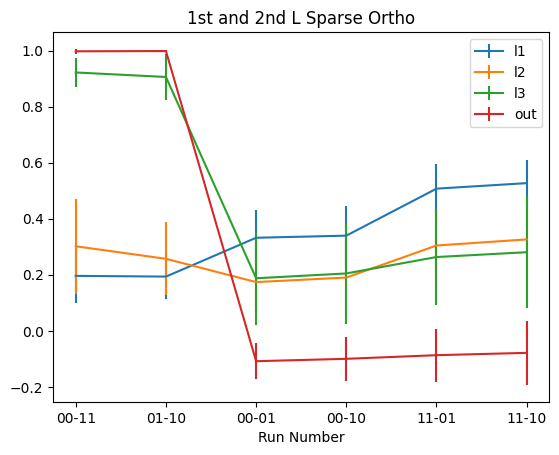

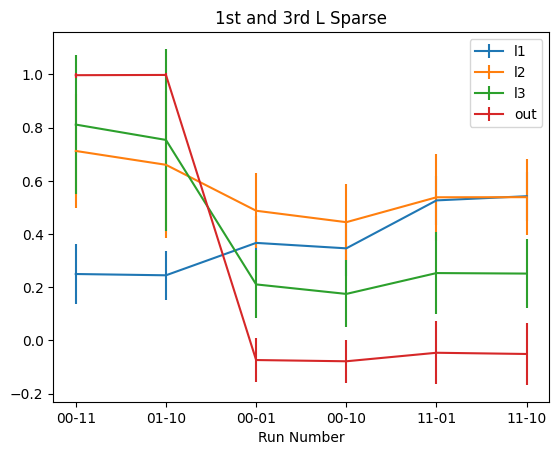

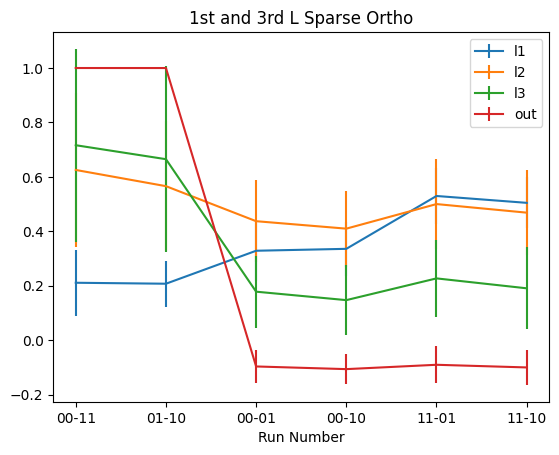

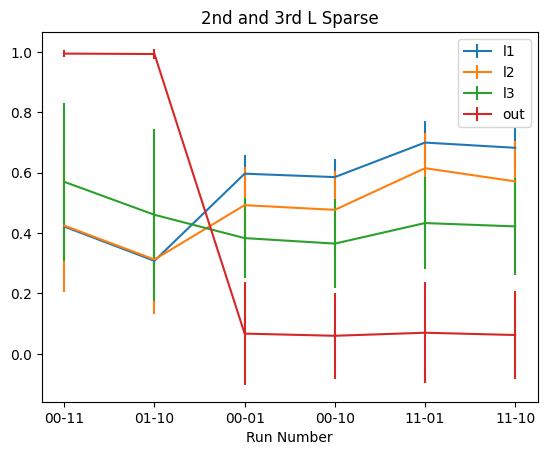

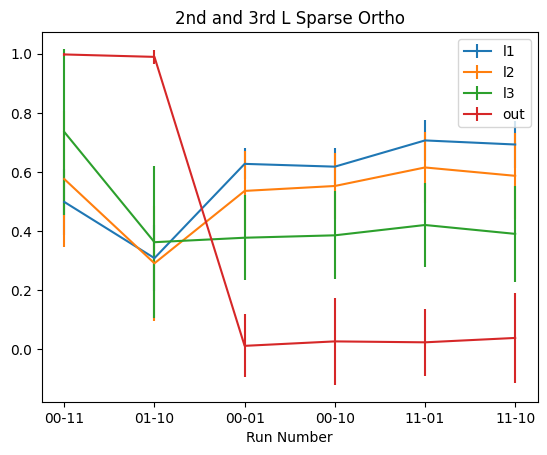

In [302]:
# figures = getLineChart(np.arange(len(allActivations)), [integration, separation], ["Integration", "Separation"])
# figures = getErrorBarChart([integration, separation], ["Integration", "Separation"])
combined = {}

for key in integration.keys():
    combined[key] = {}
    for subkey in integration[key].keys():
        combined[key][subkey] = [
    {**i, **s} for i, s in zip(integration[key][subkey], separation[key][subkey])
        ]
figures = getErrorBarChartIndivid(combined)

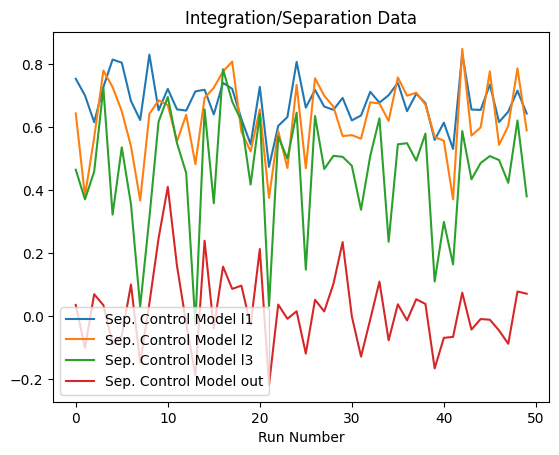

In [204]:
figures["Control Model"]['Sep.']

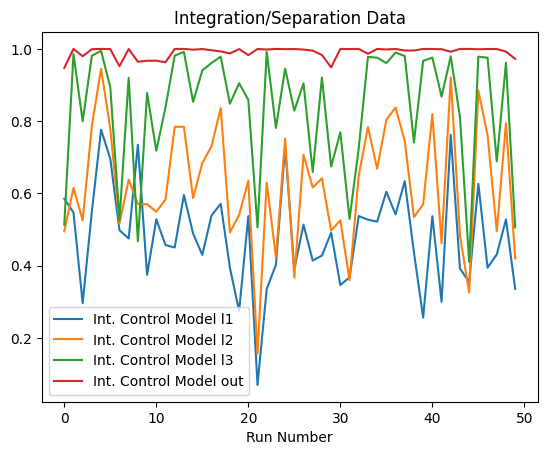

In [205]:
figures["Control Model"]['Int.']

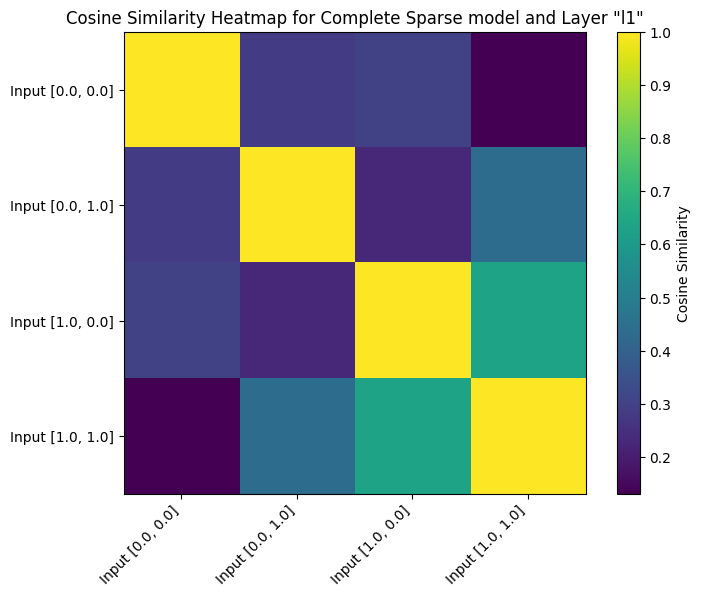

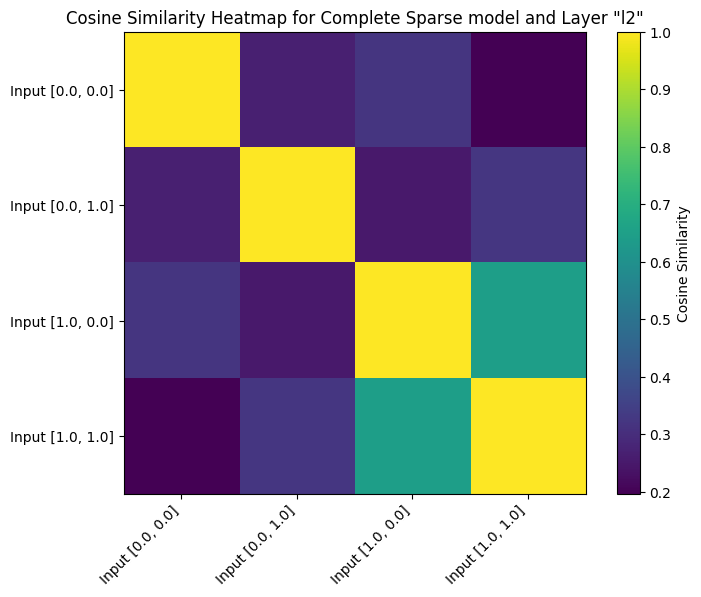

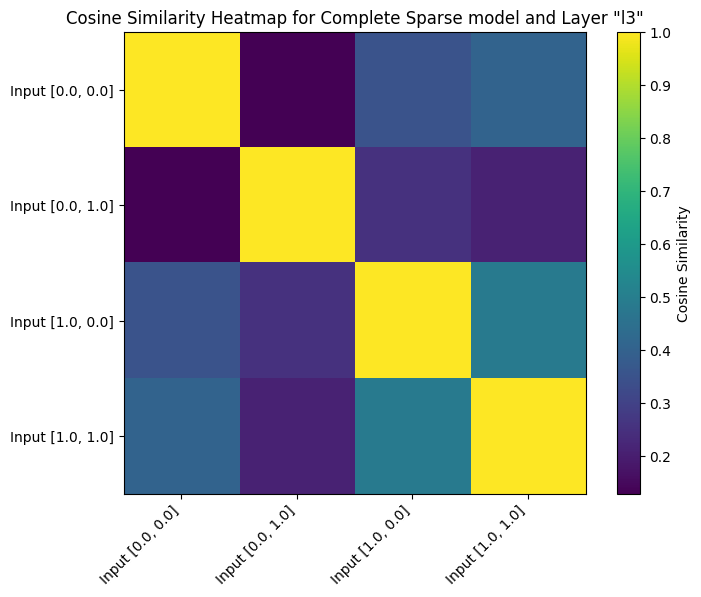

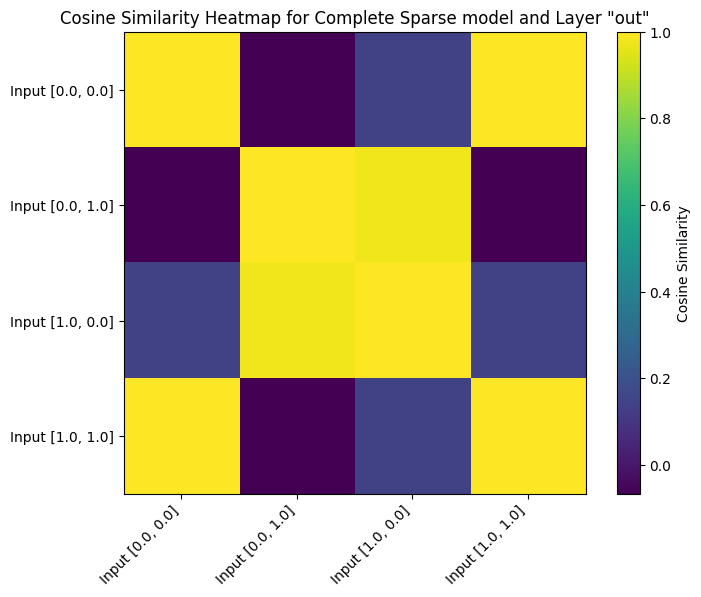

In [163]:
get_similarity_plot(sparseActivations['Complete Sparse model']['l1'], 'Complete Sparse model', 'l1')
get_similarity_plot(sparseActivations['Complete Sparse model']['l2'], 'Complete Sparse model', 'l2')
get_similarity_plot(sparseActivations['Complete Sparse model']['l3'], 'Complete Sparse model', 'l3')
fig = get_similarity_plot(sparseActivations['Complete Sparse model']['out'], 'Complete Sparse model', 'out')

/var/folders/m0/_vdtl5rj0lq8yyddkcqqj6wm0000gn/T/ipykernel_20884/1296307577.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(8, 6))


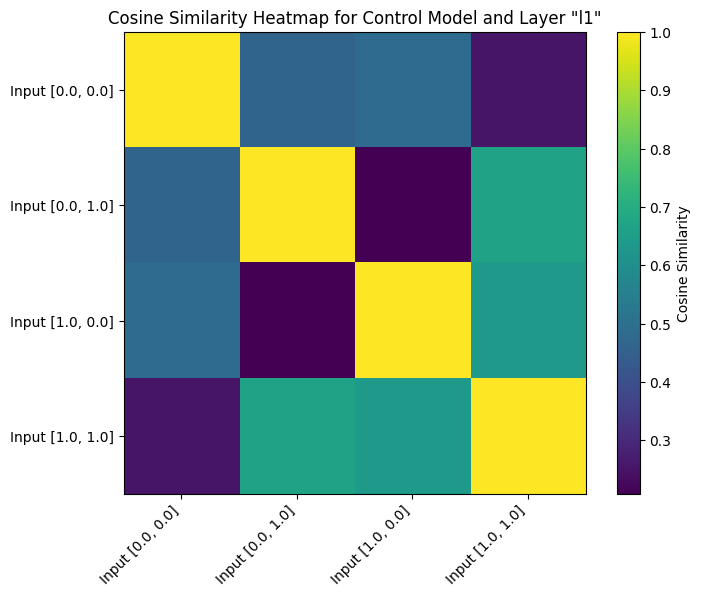

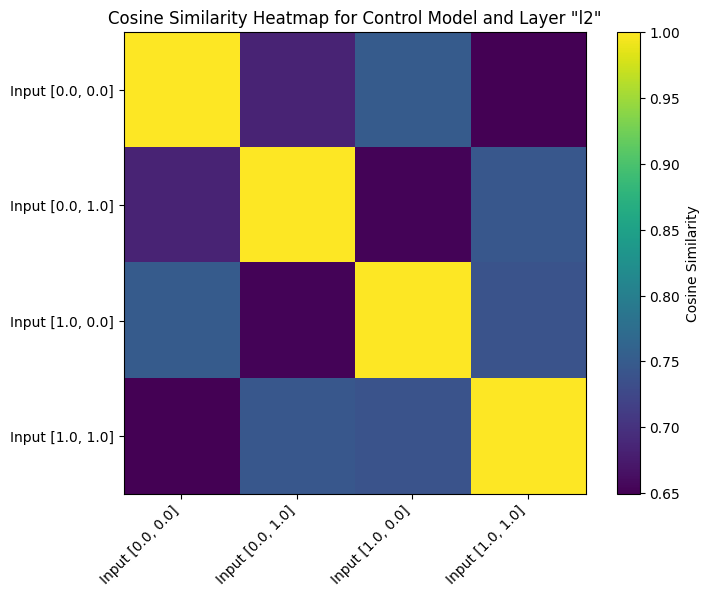

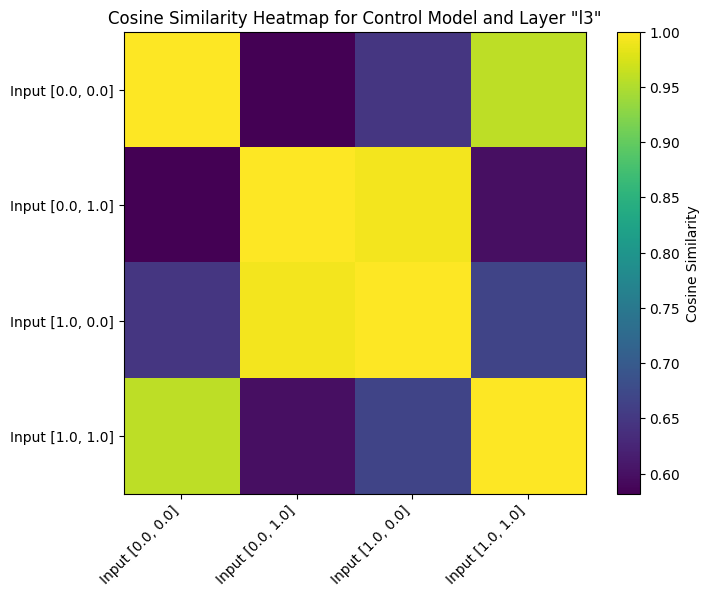

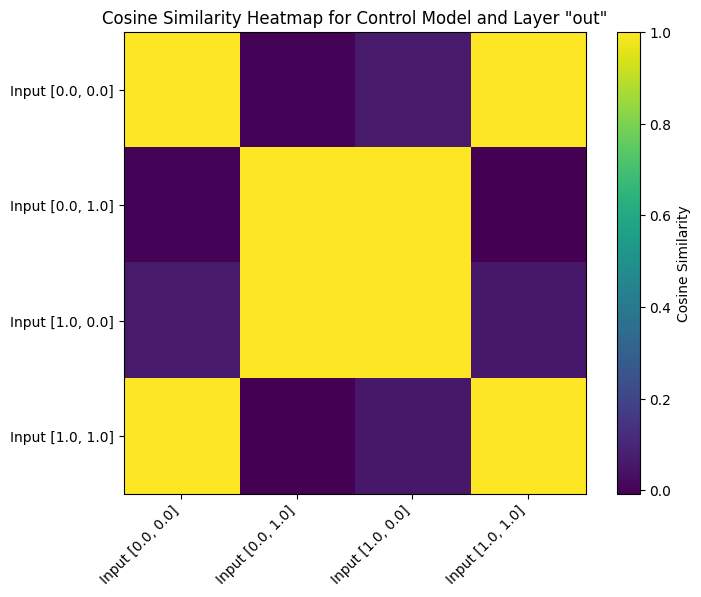

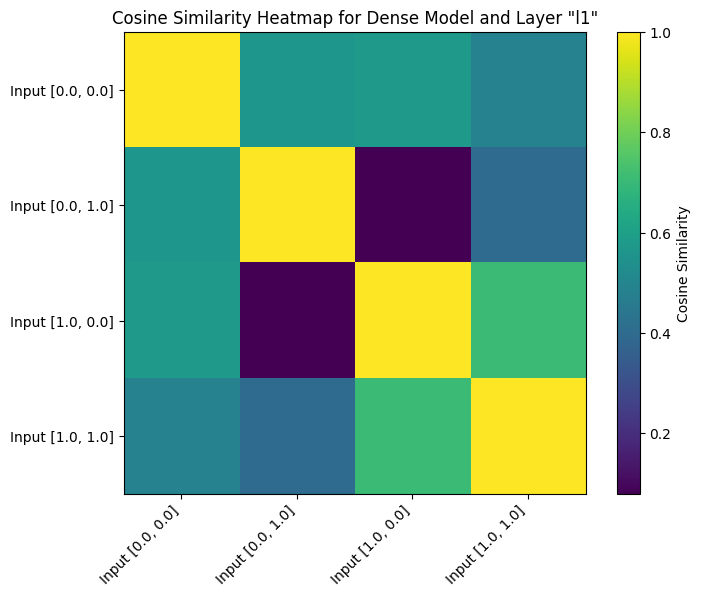

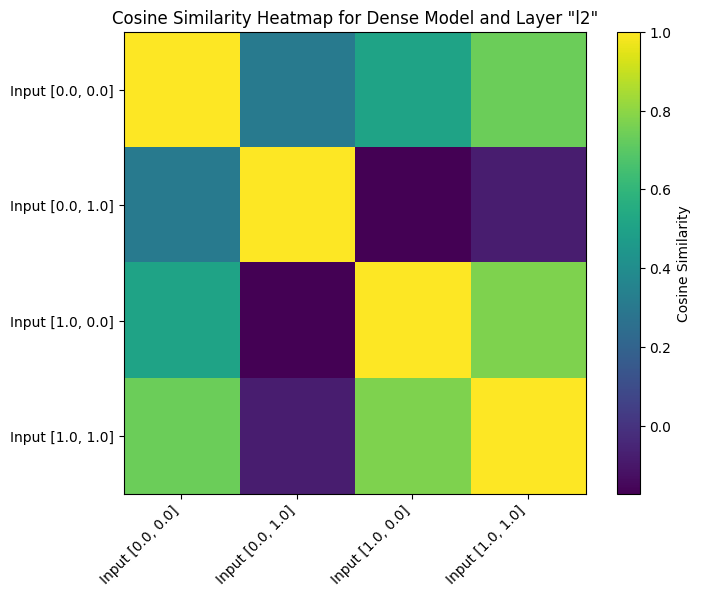

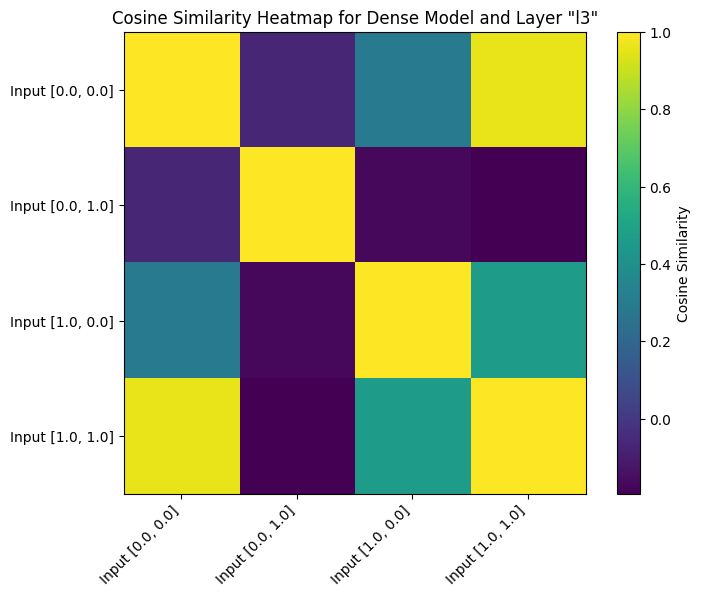

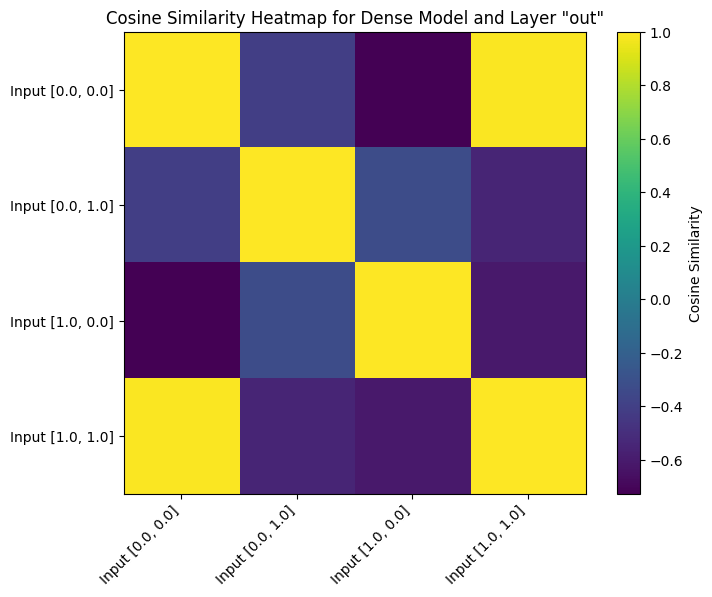

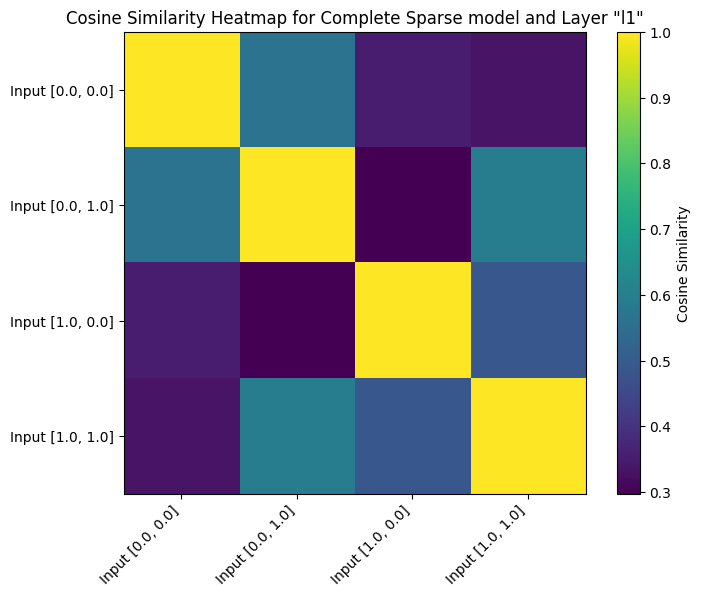

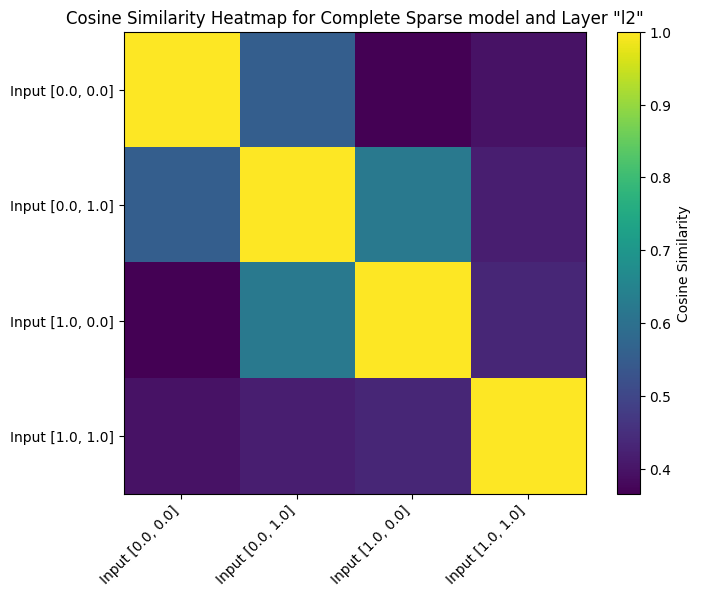

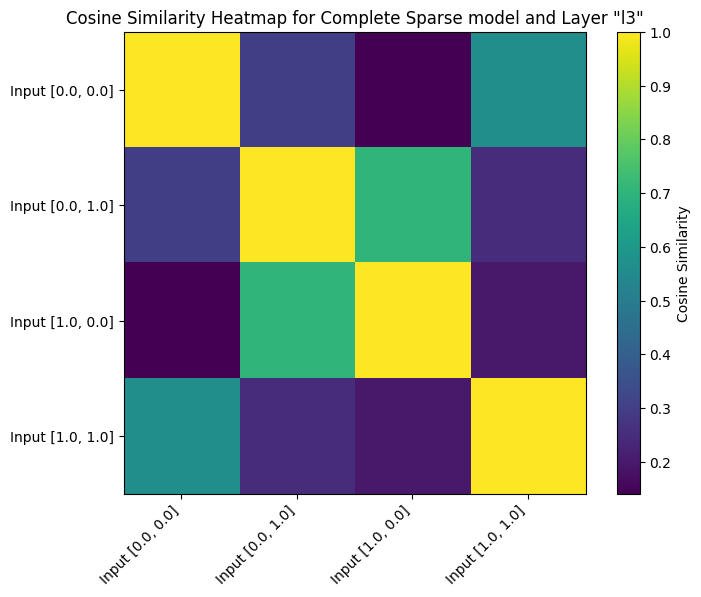

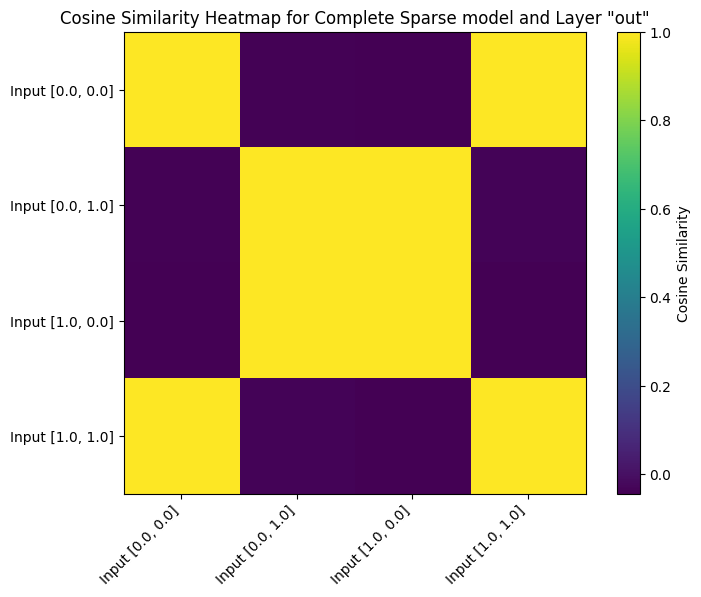

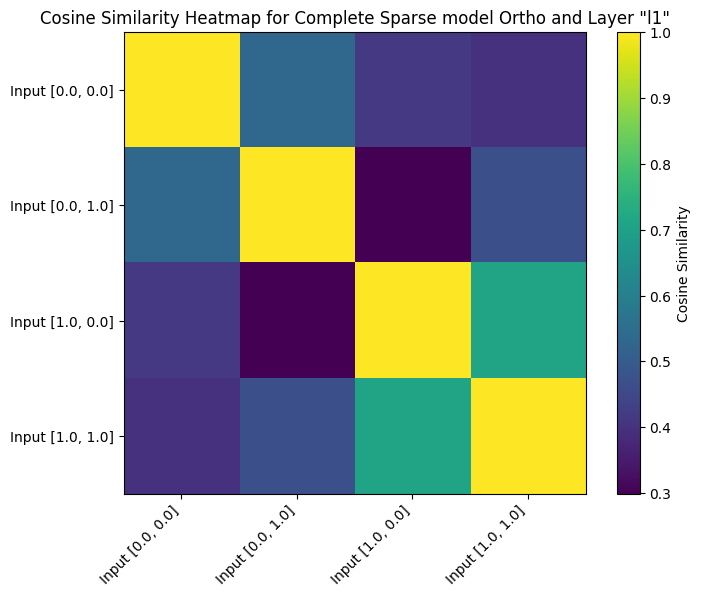

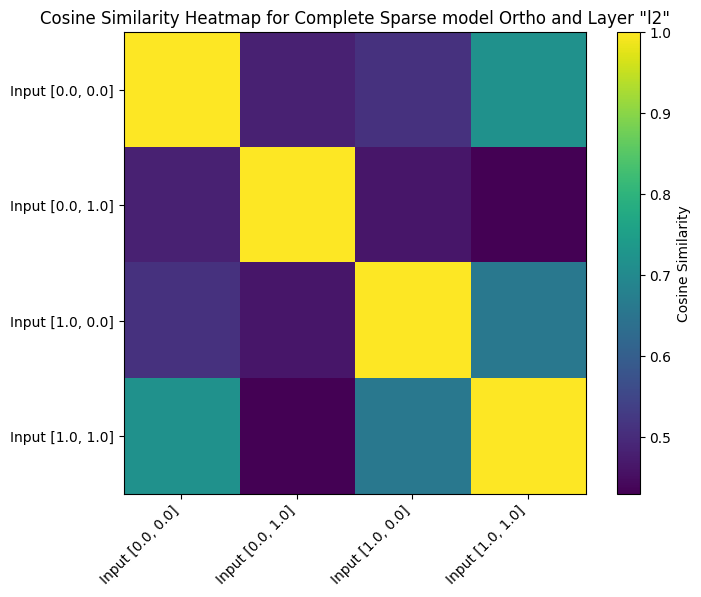

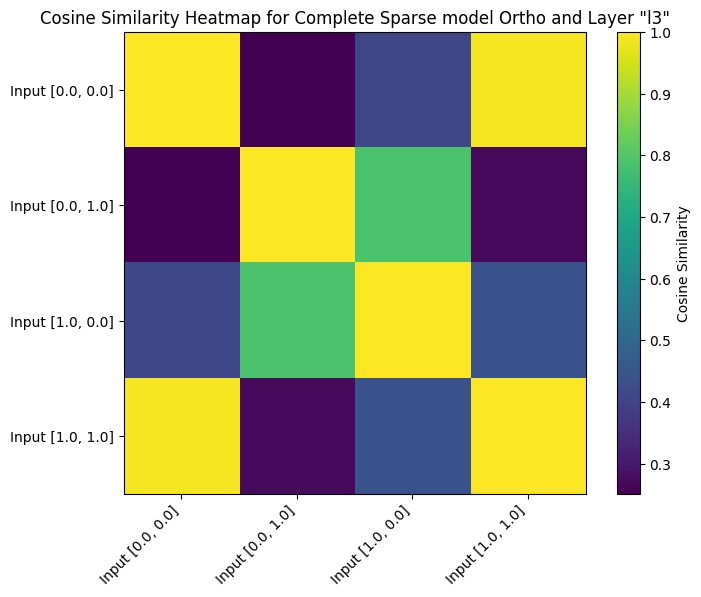

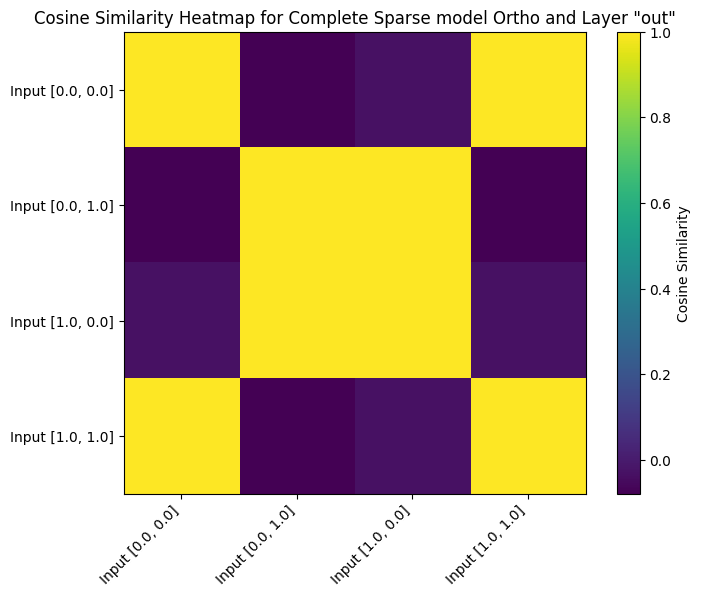

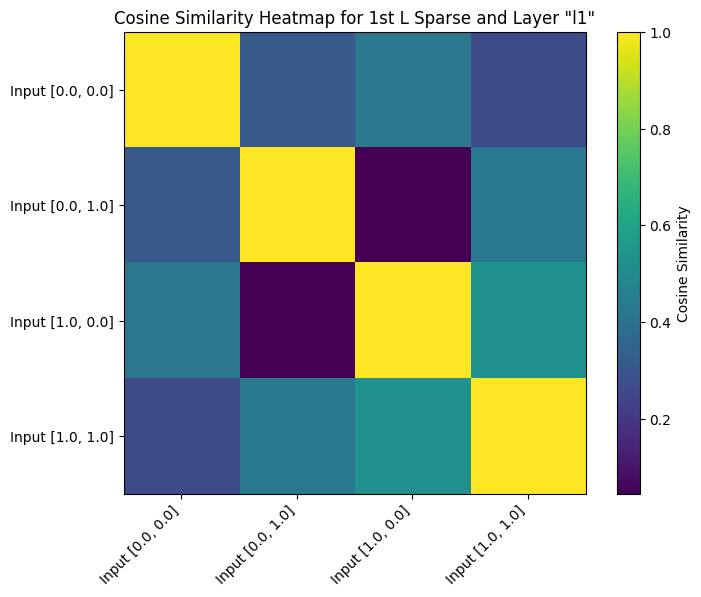

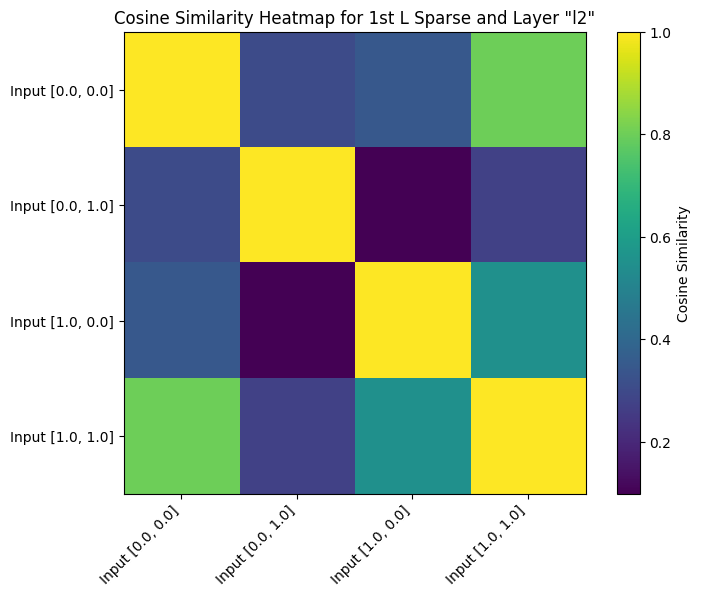

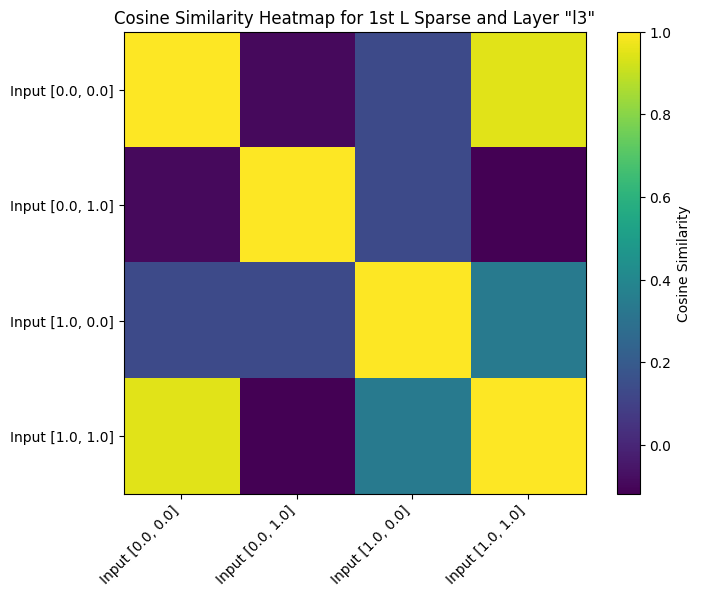

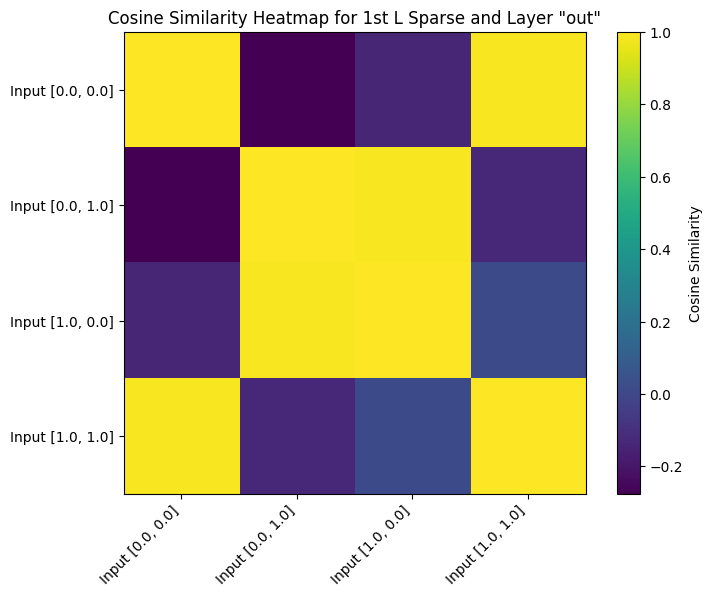

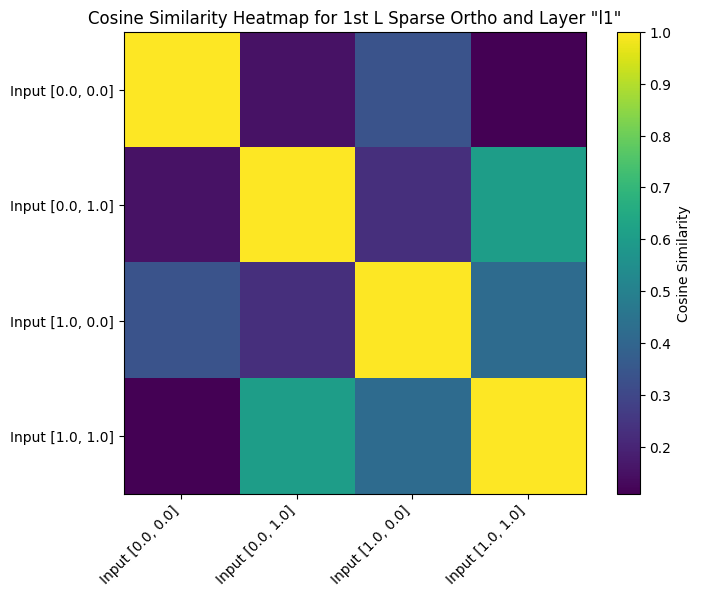

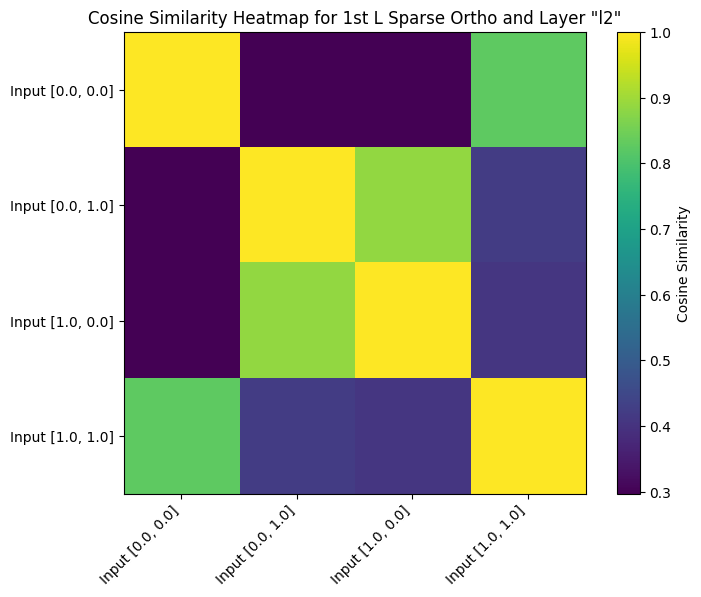

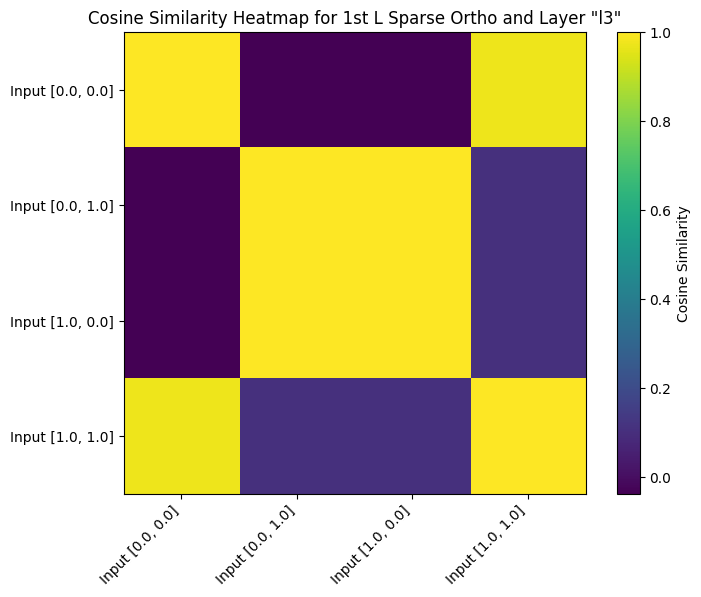

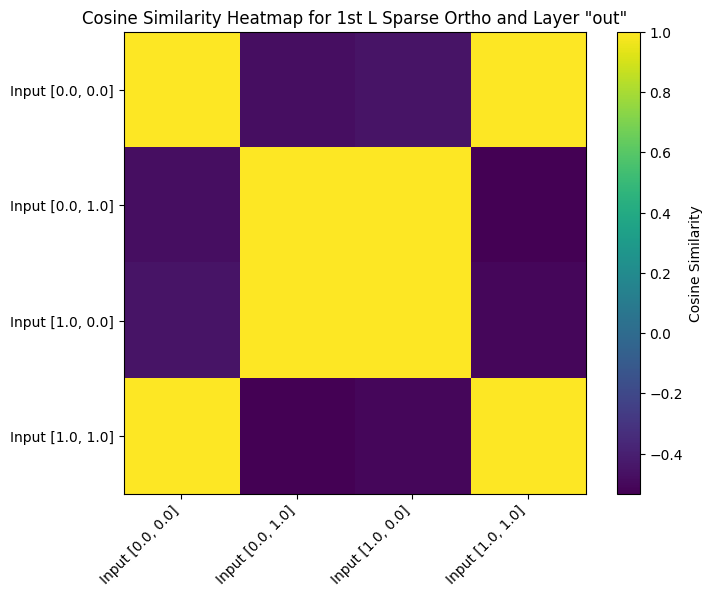

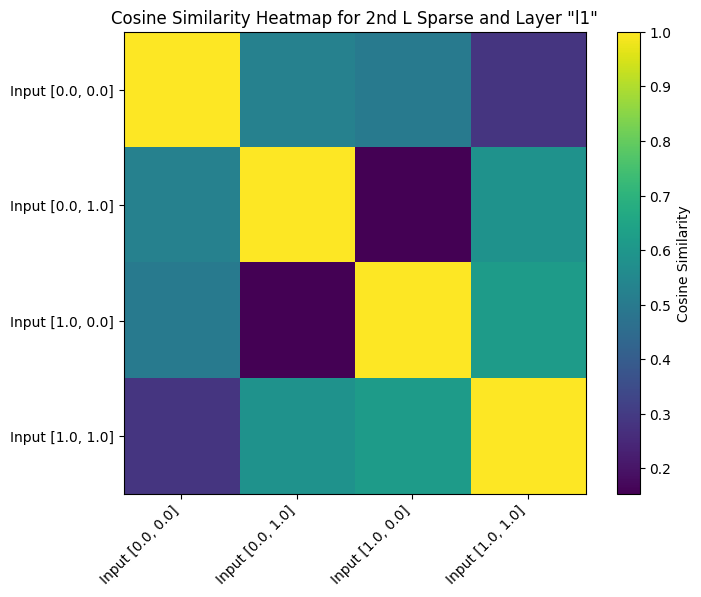

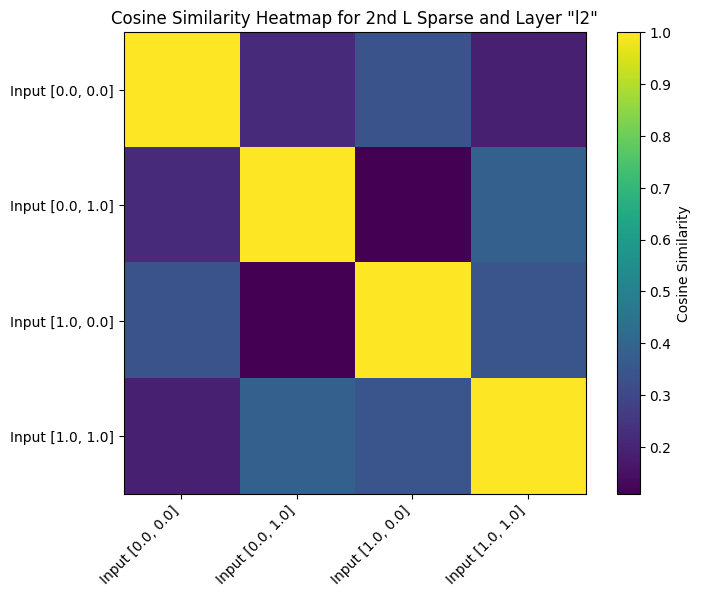

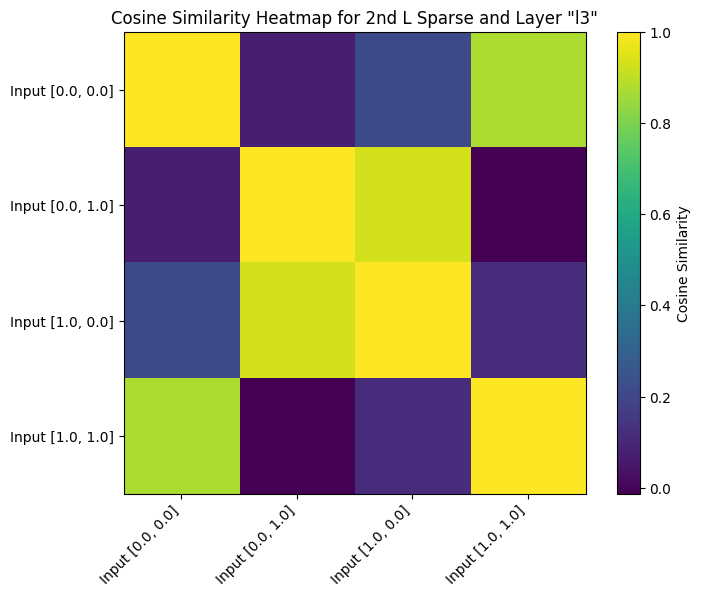

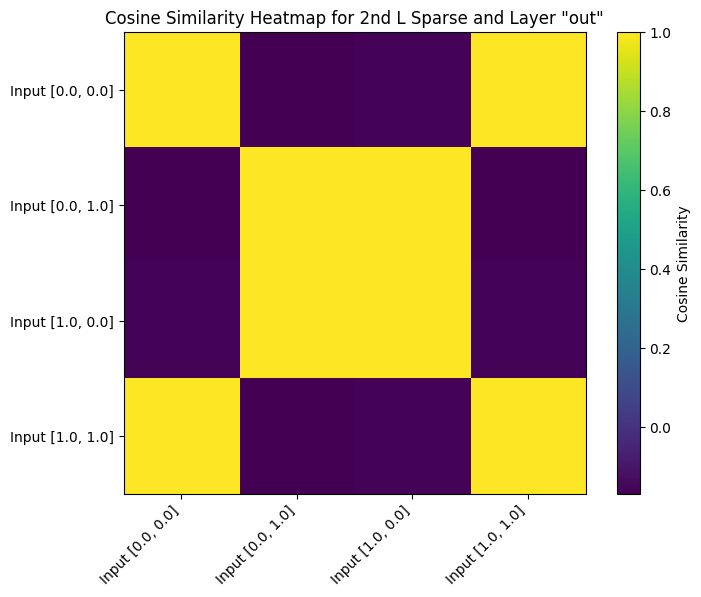

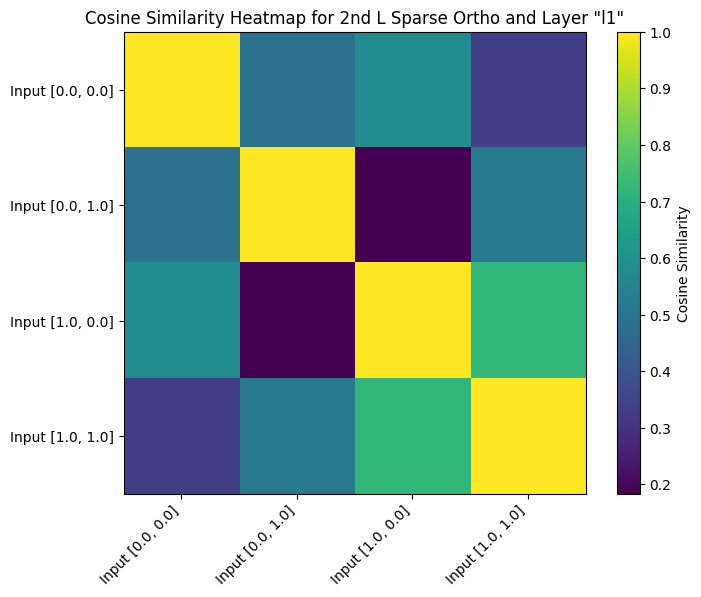

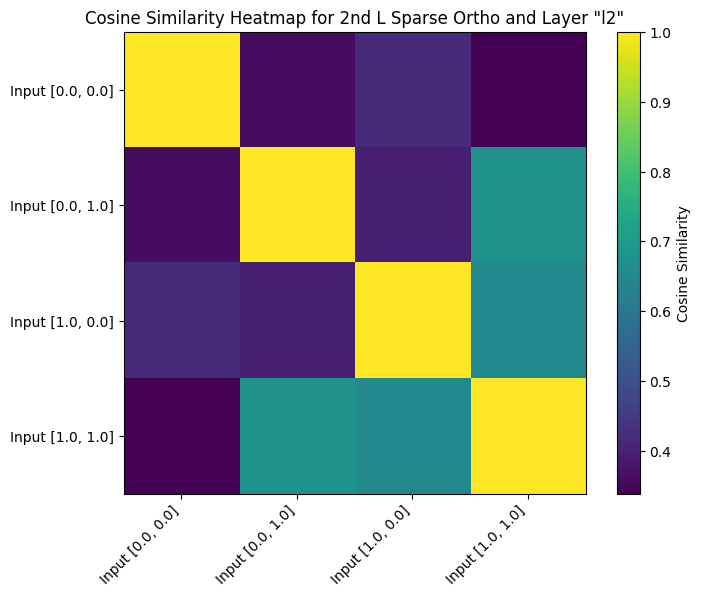

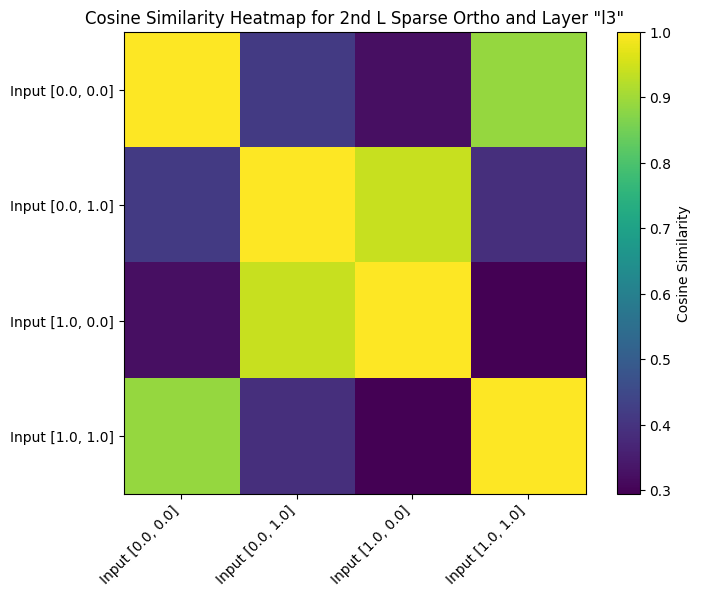

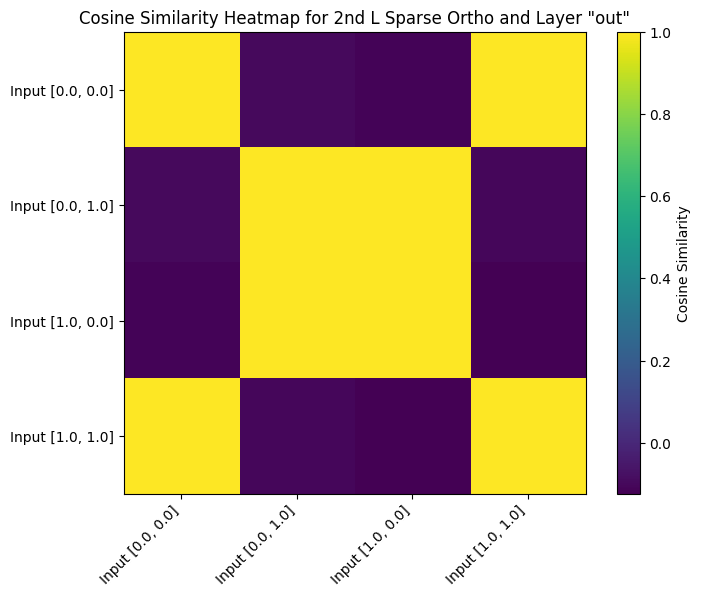

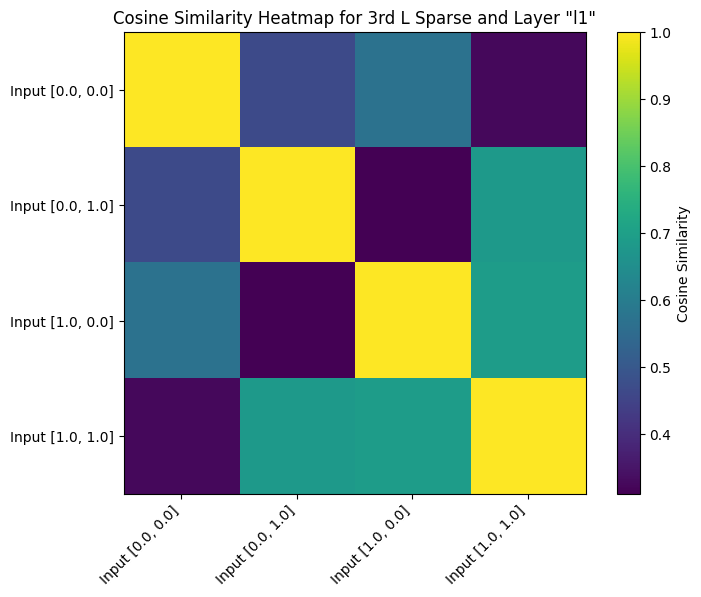

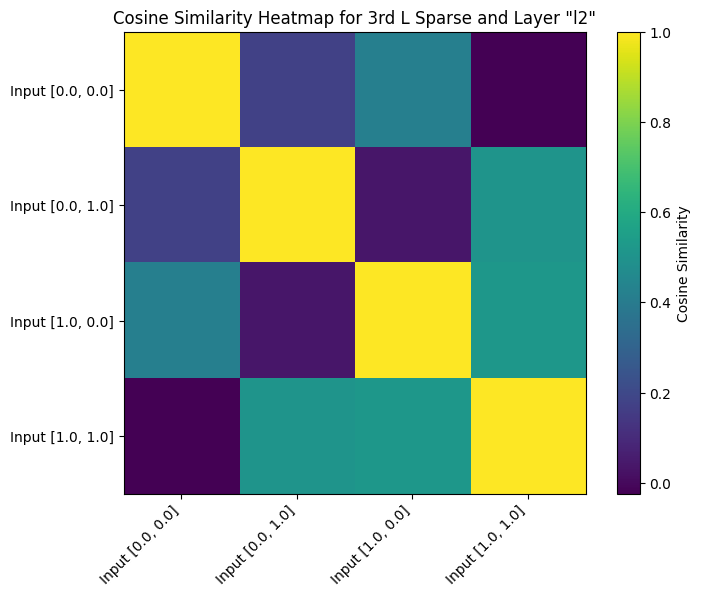

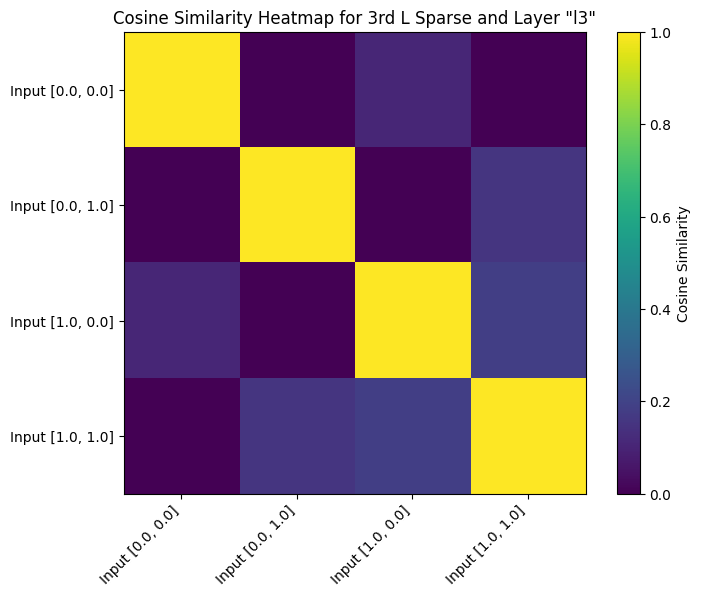

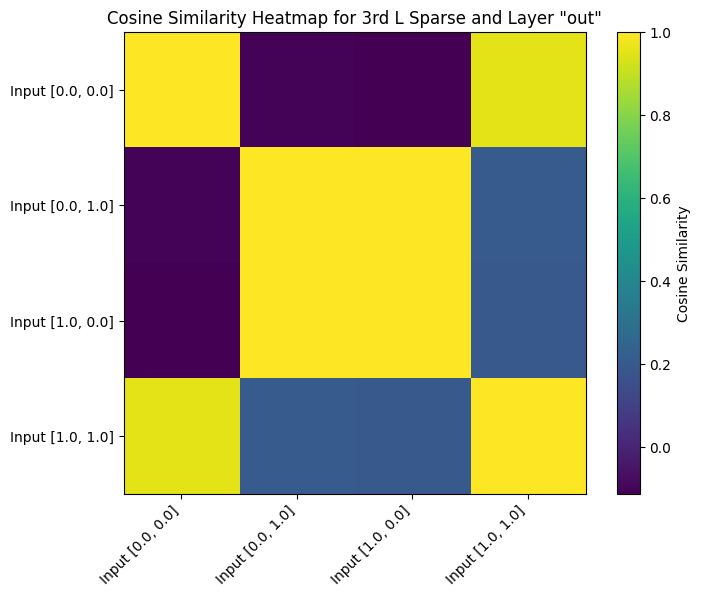

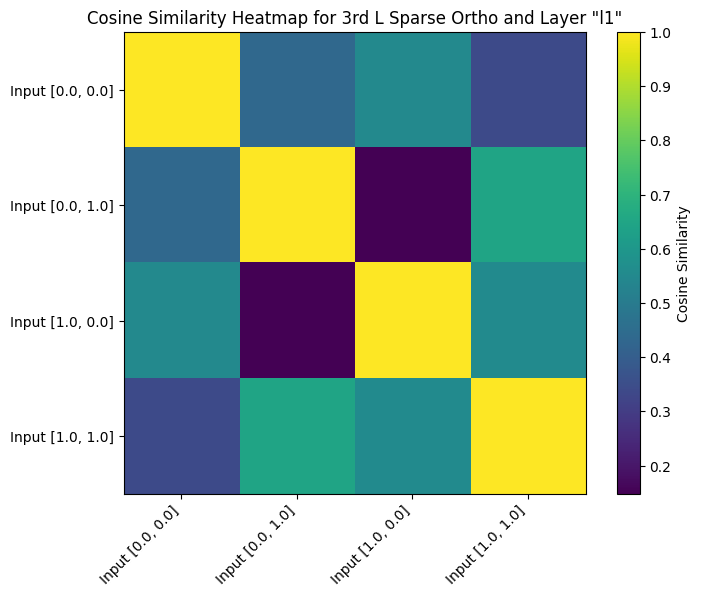

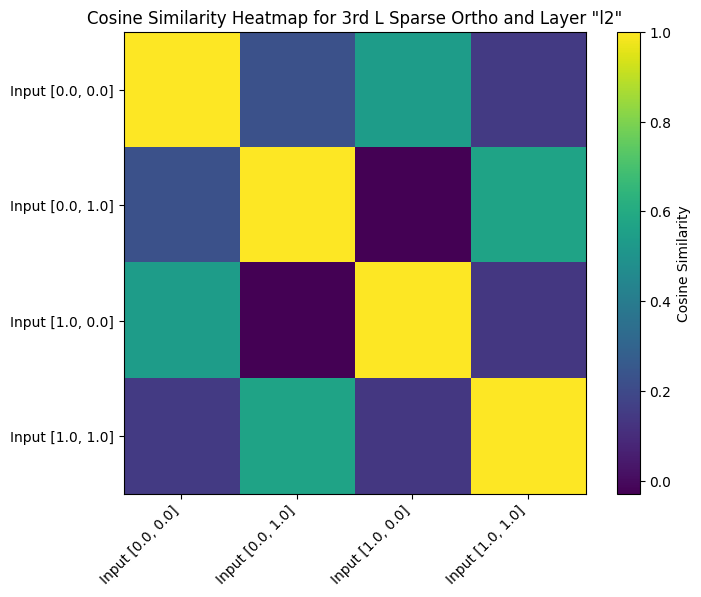

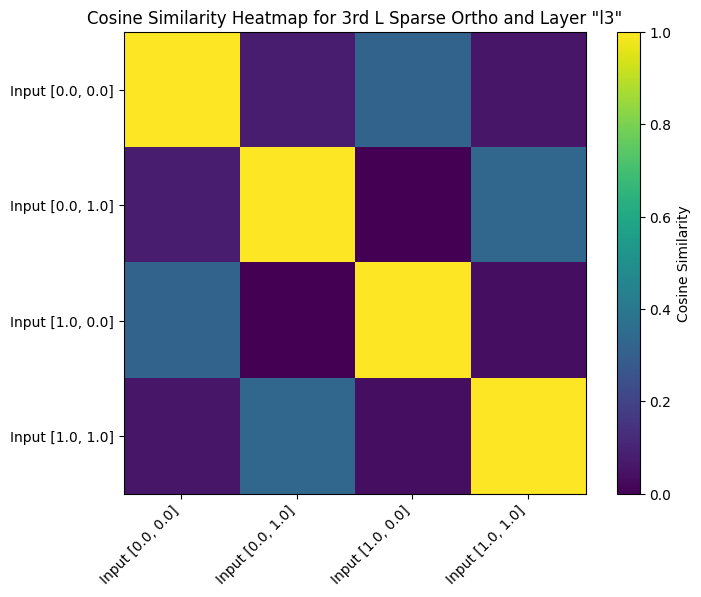

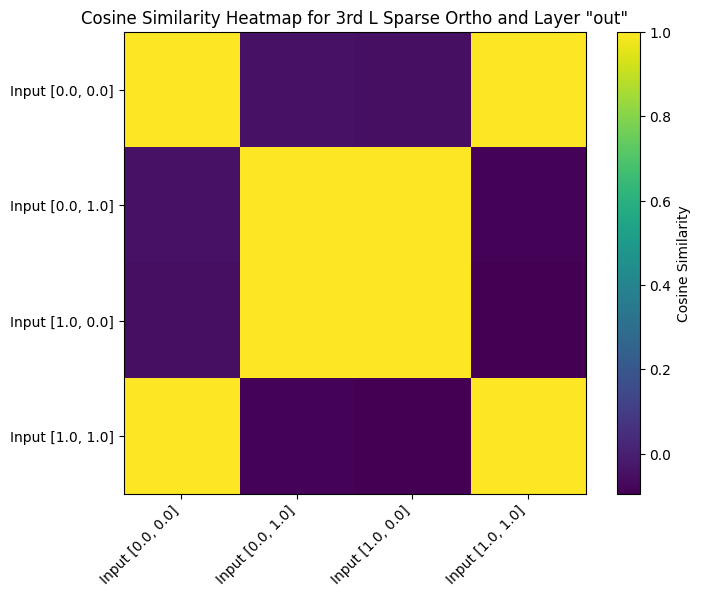

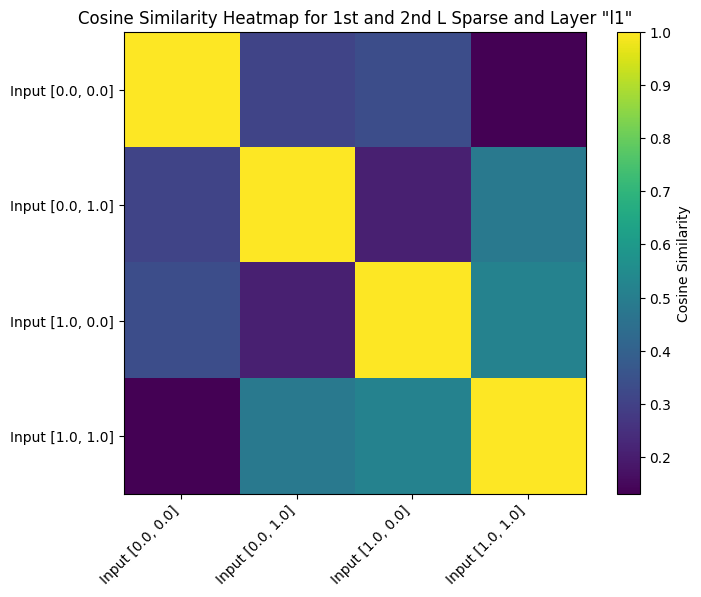

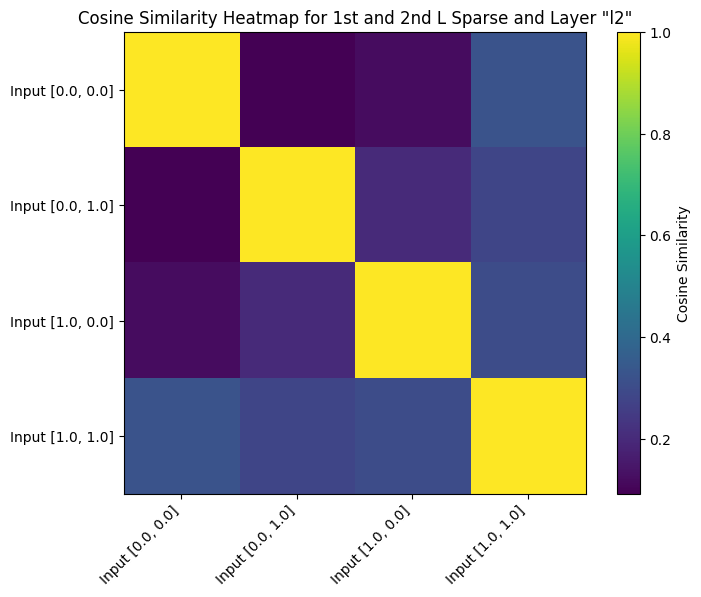

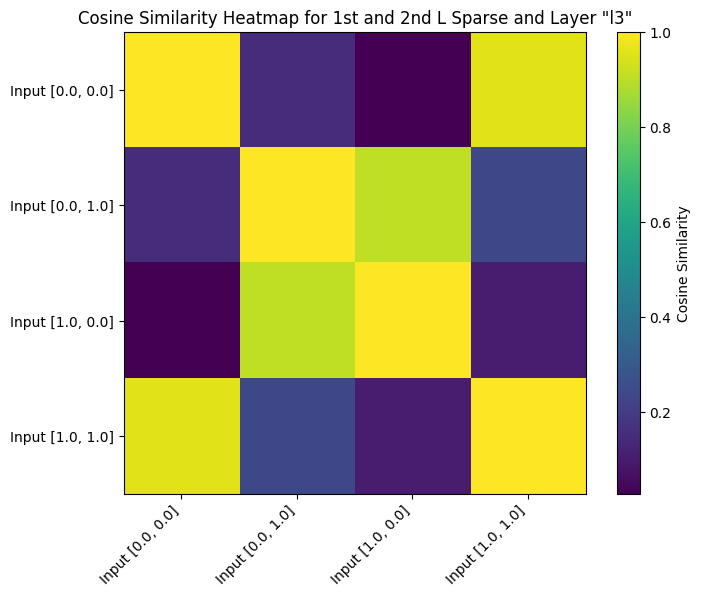

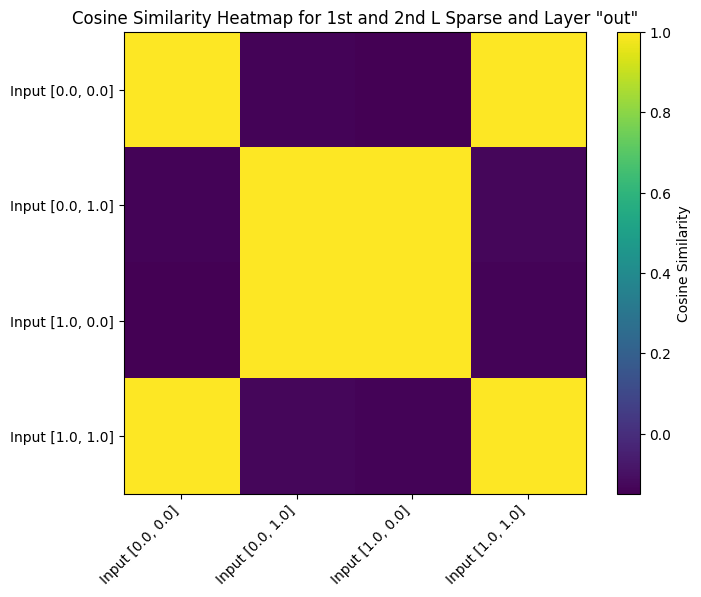

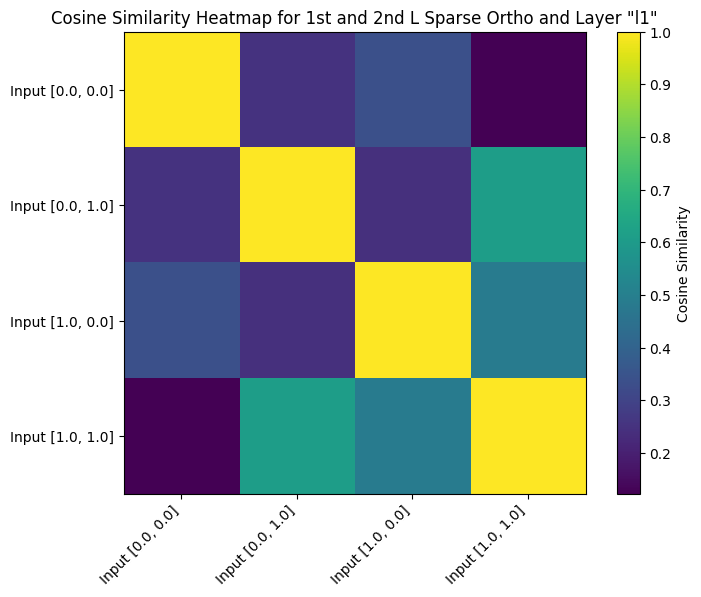

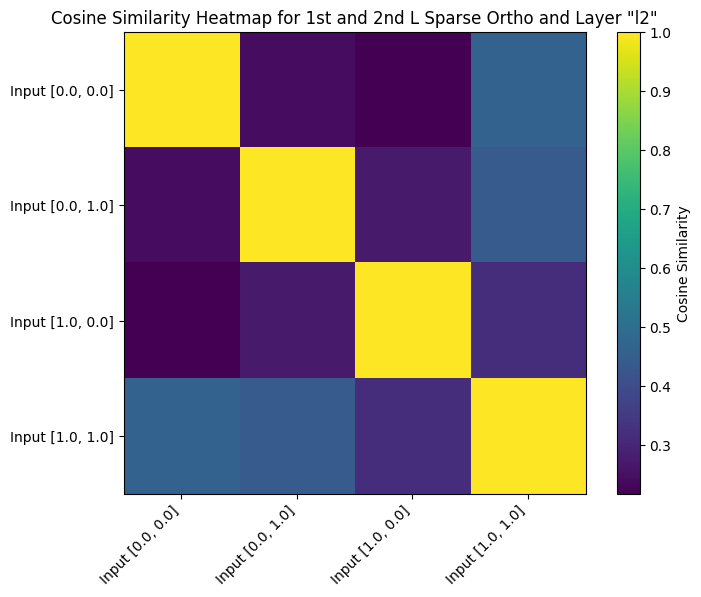

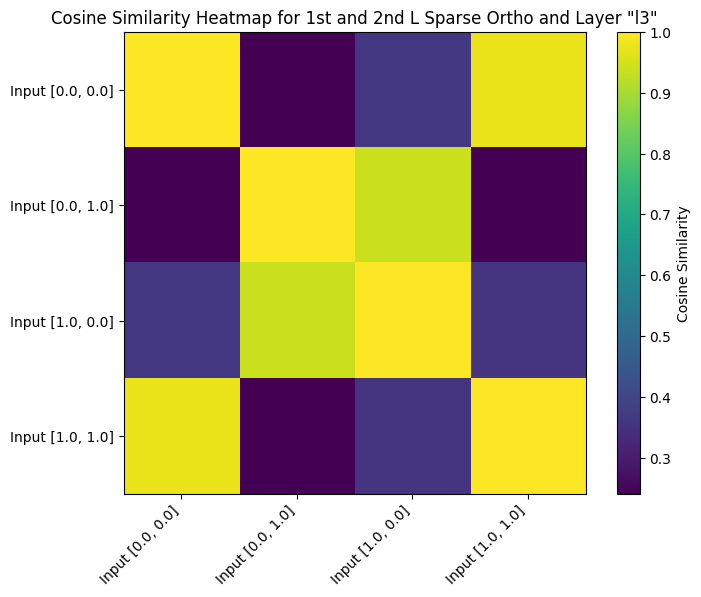

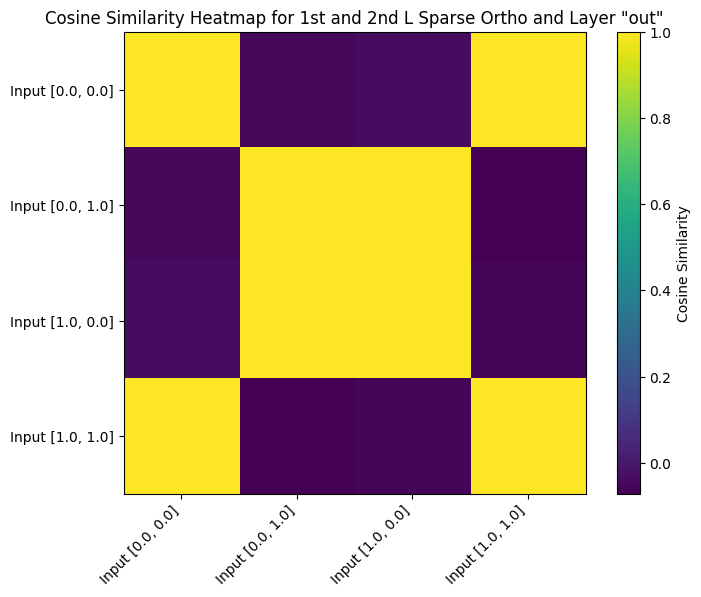

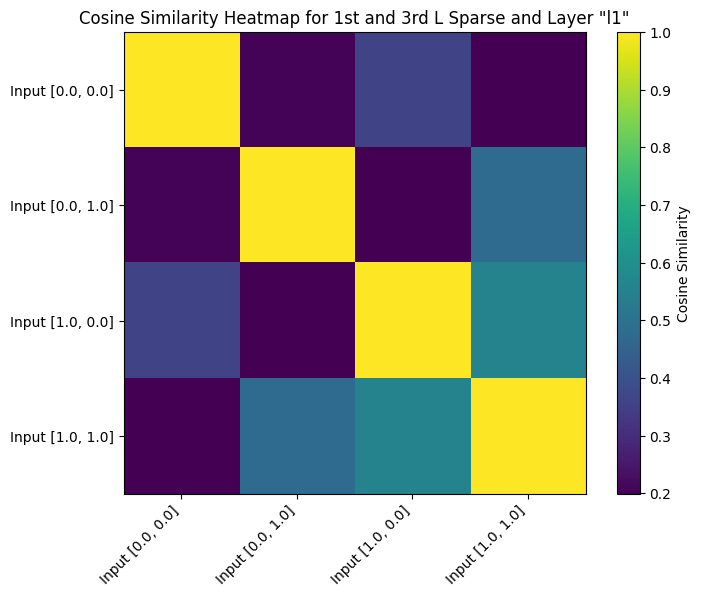

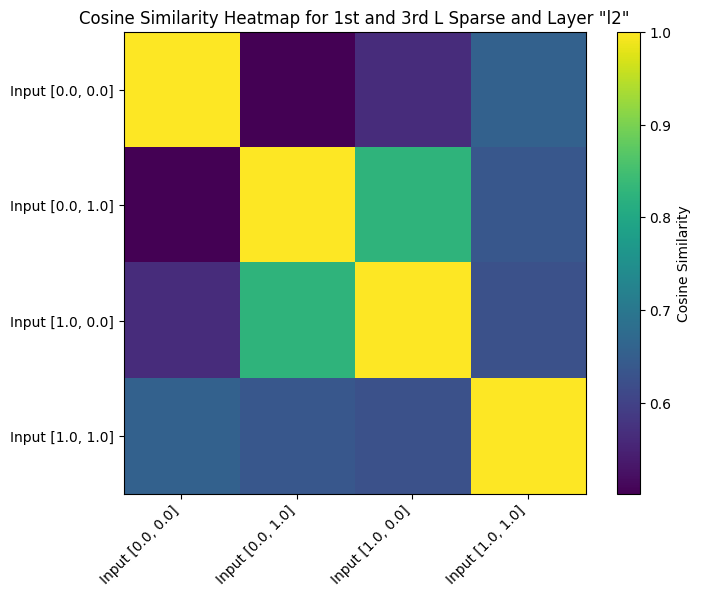

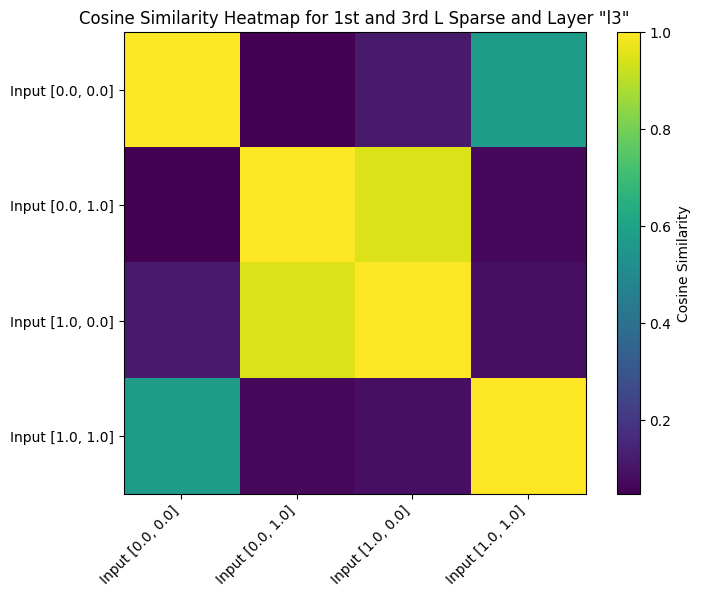

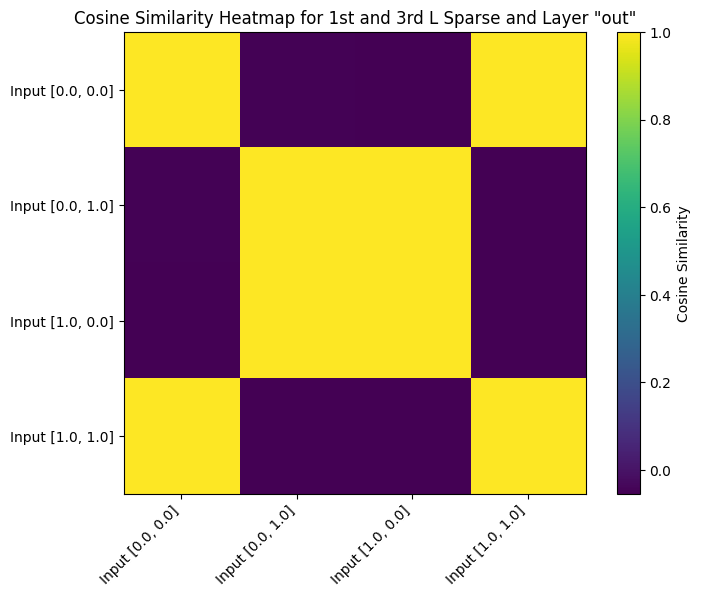

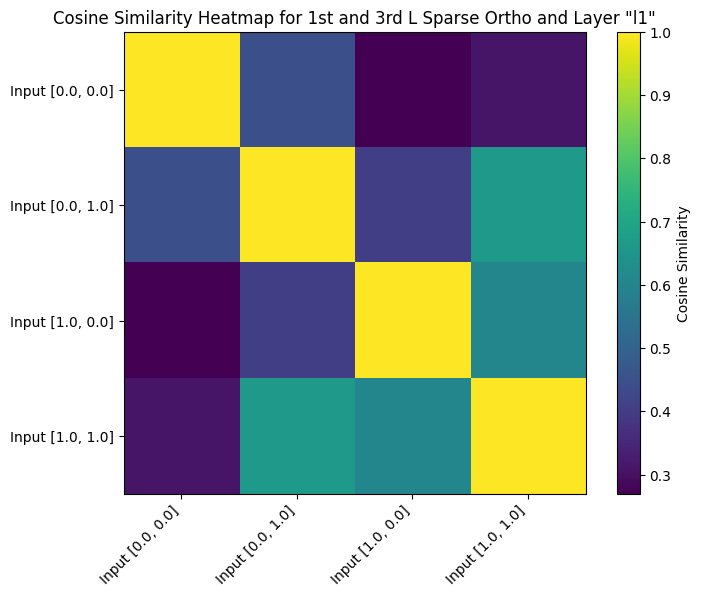

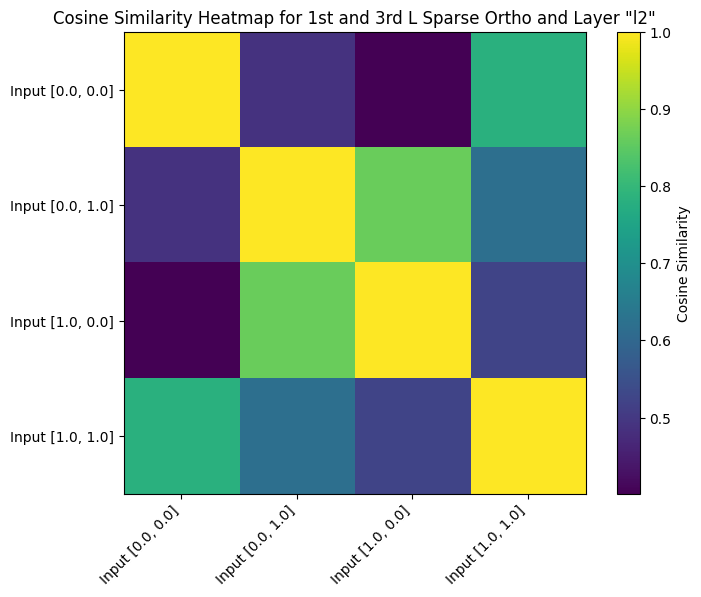

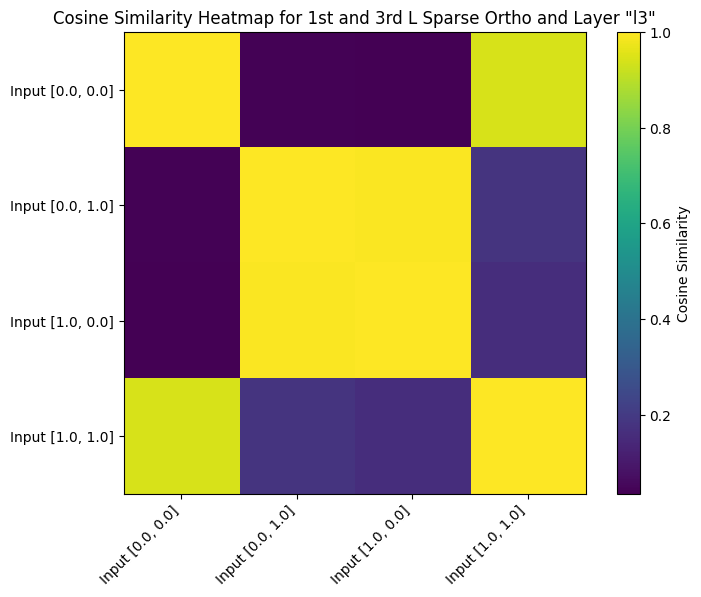

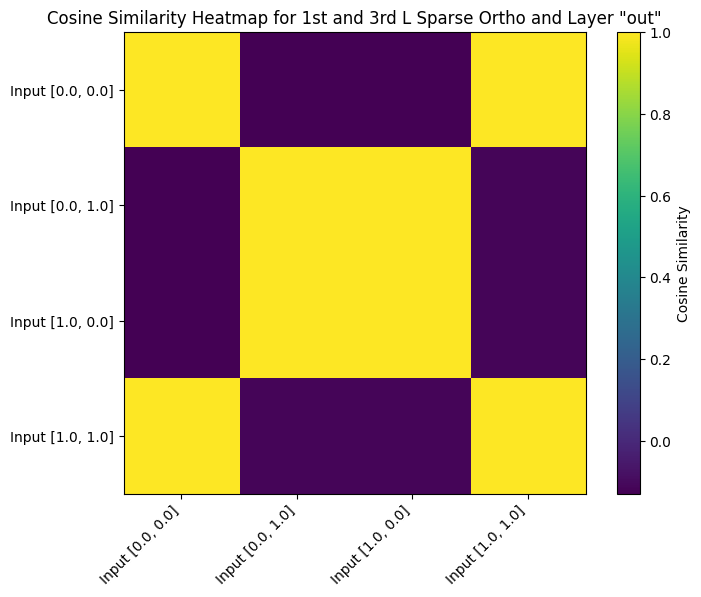

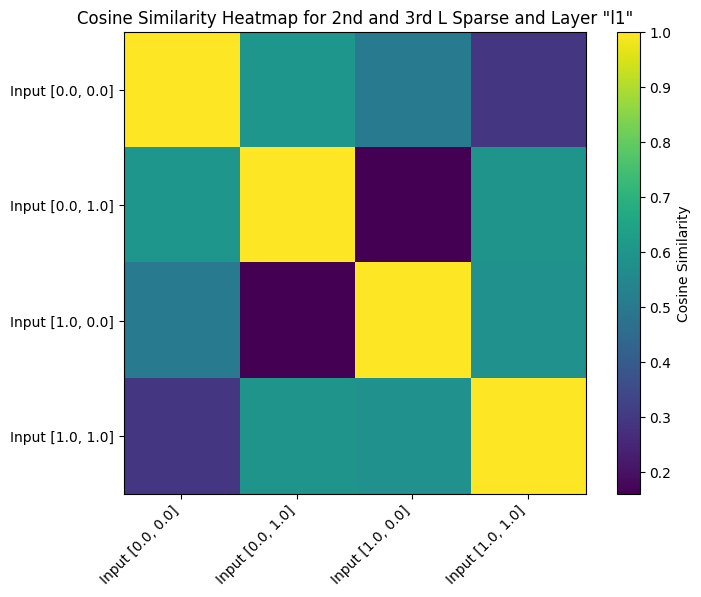

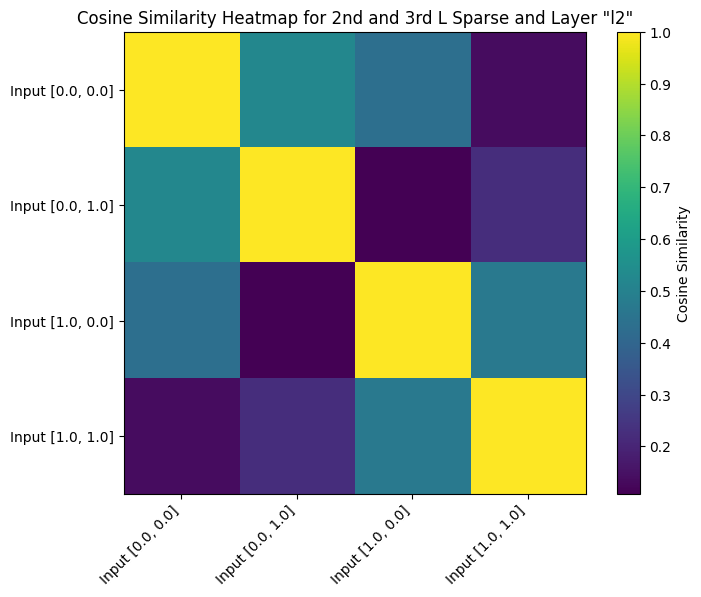

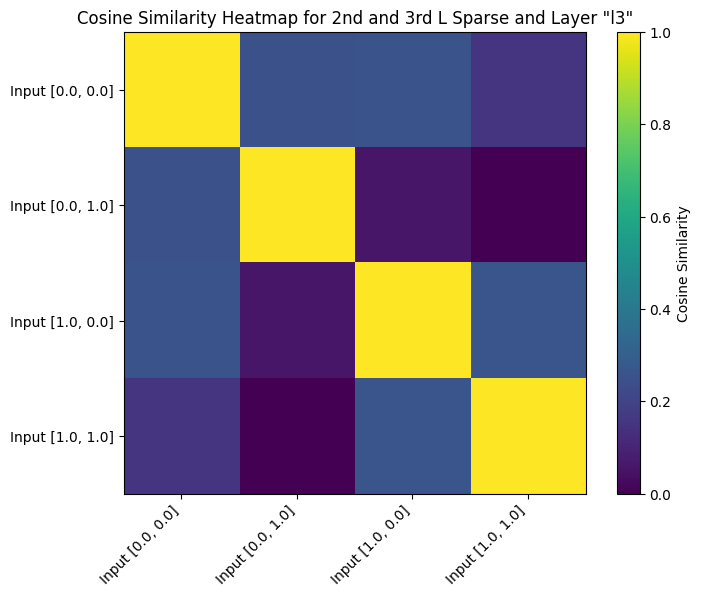

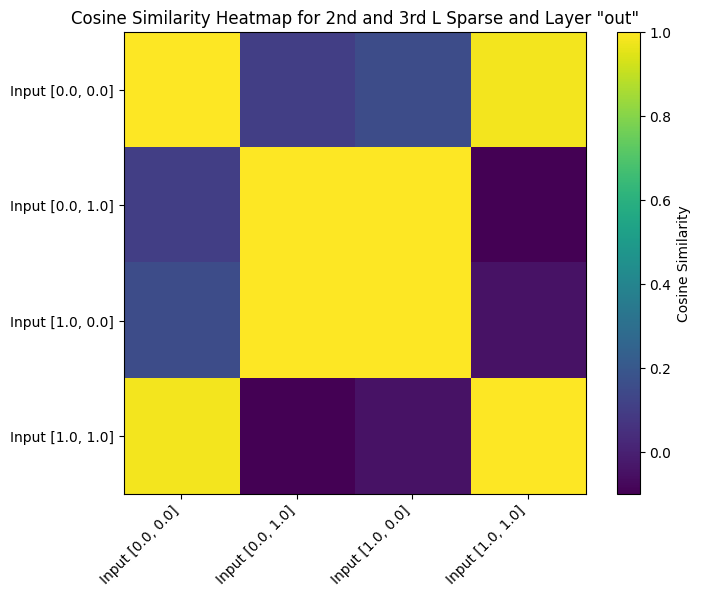

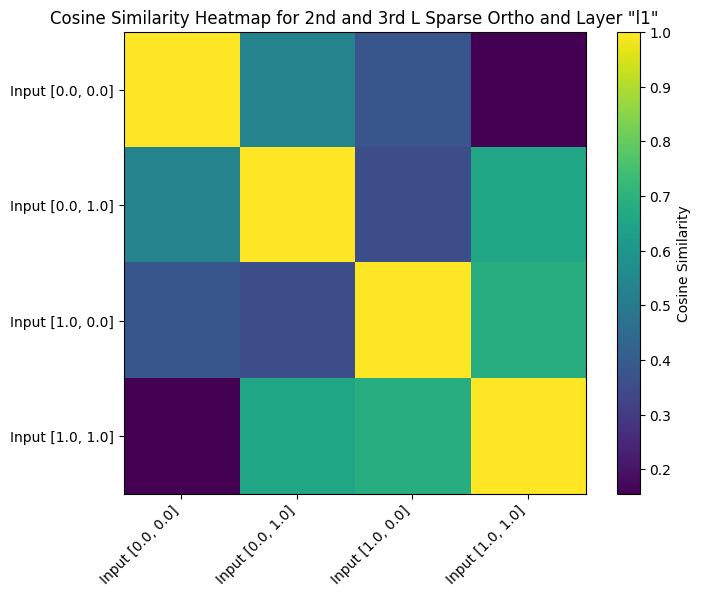

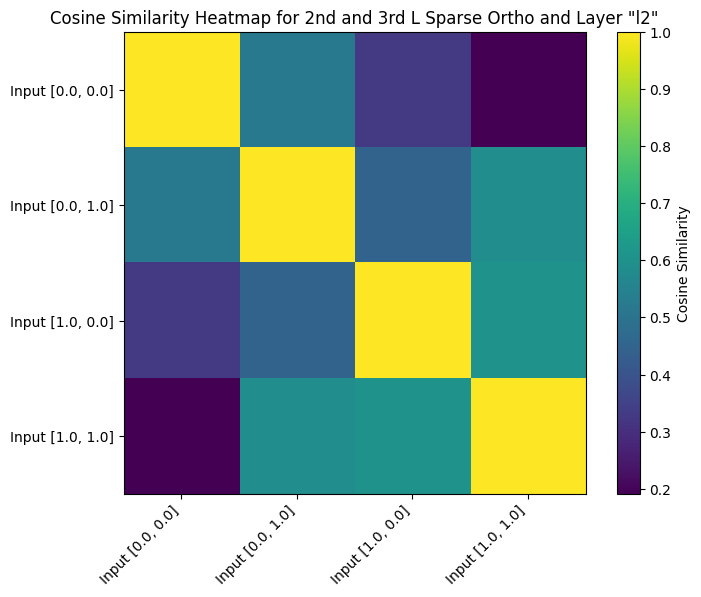

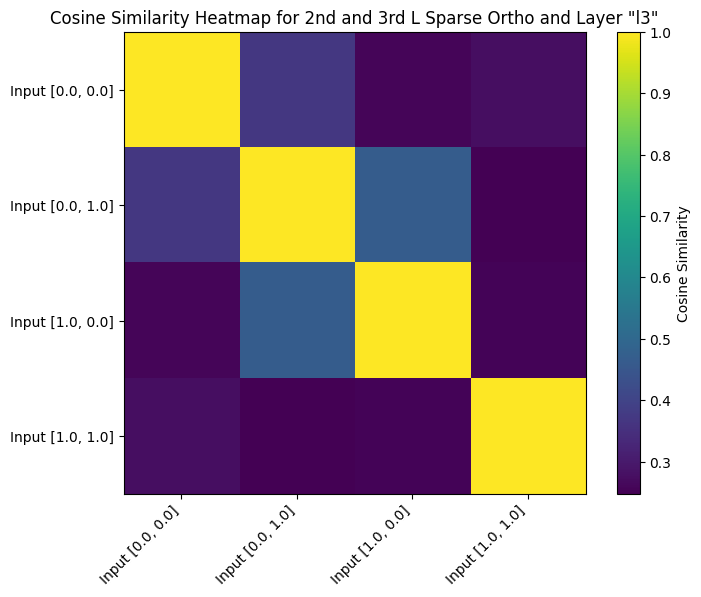

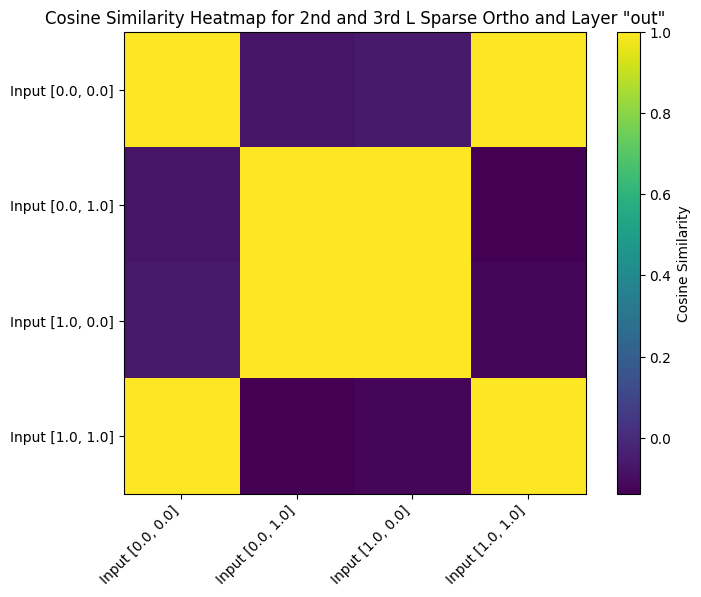

In [118]:
heatmap = {}
for modelName in sparseActivations:
    for layerName in layers:
        acts = sparseActivations[modelName][layerName]  # shape: (4, 250)

        # Compute cosine similarities
        # We'll compare each pair of the 4 activations
        num_inputs = acts.shape[0]
        if modelName not in heatmap.keys():
            heatmap[modelName] = {}
        heatmap[modelName][layerName] = get_similarity_plot(acts, modelName, layerName, num_inputs)

In [ ]:
for modelName in heatmap:
    for layer in heatmap[modelName]:
        # print("Creating heatmap for", modelName, "and layer", layer)
        heatmap[modelName][layer].imsh

dict_keys(['Control Model', 'Dense Model', 'Complete Sparse model', 'Complete Sparse model Ortho', '1st L Sparse', '1st L Sparse Ortho', '2nd L Sparse', '2nd L Sparse Ortho', '3rd L Sparse', '3rd L Sparse Ortho', '1st and 2nd L Sparse', '1st and 2nd L Sparse Ortho', '1st and 3rd L Sparse', '1st and 3rd L Sparse Ortho', '2nd and 3rd L Sparse', '2nd and 3rd L Sparse Ortho'])
dict_keys(['l1', 'l2', 'l3', 'out'])


In [104]:
fig = heatmap['Control Model']['l1']
plt.show()